In [1]:
model year%matplotlib inline

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import display, HTML
import statsmodels.api as sm
import os
import sys
import models
import patsy
from collections import defaultdict
import random
import sklearn.linear_model as linear
import sklearn.metrics
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

# Problem Set 5

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

<a id="toc"></a>

## Table of Contents

1. [ETL](#etl)
2. [EDA](#eda)
3. [Build the Model](#buildthemodel)
4. [Describe the Model](#describethemodel)
5. [Use the Model](#usethemodel)

### At the end of each section you will find a link to Table of Contents for easy navigation.

<a id="etl"></a>

## 1.1 - ETL


### Extract

First we need to perform data extraction.The data we are interested in labled as auto_mpg_data. We use Python's Pandas library in order to assist us with this task.

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv(auto_mpg_data, header=None, delim_whitespace=True)

At this point it would not hurt to find out the shape of the data to know how many rows and columns we actually have in our dataset. We can also do this in EDA, but if we are extracting the data, we might as well know how much data are we are extracting. This will also help us during the data cleaning phase as well because it will help us to know, how much data is "problematic", and what actions we should take next.

In [5]:
df.shape

(398, 9)

Now we have our data, however the data may not be in the form we would like. Specifically, there is no header. In order to help us analyze our data we need to at least have column headers so we may properly refer each feature or attribute by its given name, and not have any confusion down the road while analyzing the data.

### Transform

Looking at the auto_mpg_name file we notice that there are 9 attributes including class. These attributes will serve as the header for our data and are as follows: 

    1. mpg
    2. cylinders
    3. displacement
    4. horsepower
    5. weight
    6. acceleration
    7. model year
    8. origin
    9. car name

In [6]:
attributes = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]
df.columns = attributes

Now we have attribute names and can refer to the columns by their name instead of indexes assigned by Pandas. However, we must also check for any missing as this is also an important part of data transformation. We know that we are dealing with numbers whether continous or discrete. Therefore, if there is a value that is not a number, it must be treated as a missing value. We can simply force columns (not all columns) to be numeric, and the non-numeric values will be converted to NaN (if they are not already), which we can deal with as we please.

In [7]:
def force_numeric(df):
    for column in df.columns:
        if column != "car name":
            df[column] = pd.to_numeric(df[column],errors='coerce')

In [8]:
force_numeric(df)

We need to know how many values are missing in our dataset, and what to do with them. We do this because if they are few values missing in a large dataset, we can simply remove them as their impact should not be great, however if a lot of values are missing we may need to reconsider our data extraction.

In [9]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

We notice here that there are in total 6 missing rows, and all of those rows are horsepower attribute. Furthermore, as we found out above the shape of our data is 398 rows, and 9 columns. We can simply drop these rows and we will still have enough data to work with. We can drop these rows as follows:

In [10]:
df = df.dropna()

In transformation we added attribute names to our dataframe, we also cleaned the data by removing 6 missing values in the dataset. We can now begin to load the data. We should also make sure that car names are spelled correctly. In order to do that we will obtain a list of manufacturers in the 1970s to match manufacturers against. We will also change abbreviations to full name. For instance sometimes people refer to chevrolet as chevy. 

In [11]:
def car_name_checker(df):
    unique = []
    for index, row in df.iterrows():
        car_name = row["car name"]
        manufacturer = car_name.split()[0]
        if manufacturer not in unique:
            unique.append(manufacturer)
    return unique

In [12]:
print(car_name_checker(df))

['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac', 'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi', 'saab', 'bmw', 'chevy', 'hi', 'mercury', 'opel', 'fiat', 'oldsmobile', 'chrysler', 'mazda', 'volvo', 'renault', 'toyouta', 'maxda', 'honda', 'subaru', 'chevroelt', 'capri', 'vw', 'mercedes-benz', 'cadillac', 'mercedes', 'vokswagen', 'triumph', 'nissan']


We notice that Toyota, Chevrolet, Mazda, and Volkswagen are misspelled as Toyouta, Chevroelt, Maxda, and Vokswagen. We definitely have some abbreviations as well. Let's clean the data.

In [13]:
def clean_car_name(df):
    bad_naming = ["maxda", "chevroelt", "toyouta", "vw", "vokswagen", "chevy"]
    for index, row in df.iterrows():
        if row["car name"].split()[0] in bad_naming:
            if row["car name"] == "maxda":
                df.loc[index, "car name"] = "mazda"
            elif row["car name"] == "chevroelt" or "chevy":
                df.loc[index, "car name"] = "chevrolet"
            elif row["car name"] == "toyouta":
                df.loc[index, "car name"] = "toyota"
            elif row["car name"] == "vw" or "vokswagen":
                df.loc[index, "car name"] = "volkswagen"
                print(row)

In [14]:
clean_car_name(df)

In [15]:
print(car_name_checker(df))

['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac', 'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi', 'saab', 'bmw', 'hi', 'mercury', 'opel', 'fiat', 'oldsmobile', 'chrysler', 'mazda', 'volvo', 'renault', 'honda', 'subaru', 'capri', 'mercedes-benz', 'cadillac', 'mercedes', 'triumph', 'nissan']


It appears that we have fixed our problems. First we cleaned the numbers, we made sure that there were not missing values, and then we made sure that the car names were spelled correctly. We don't know when and where we will find car name feature necessary for our analysis, it is best to have it cleaned.

### Load

*Data loading is the process of copying and loading data or data sets from a source file, folder or application to a database or similar application. It is usually implemented by copying digital data from a source and pasting or loading the data to a data storage or processing utility.*

Generally, *in this phase, extracted and transformed data is loaded into the end target source which may be a simple delimited flat file or a Data Warehouse depending on the requirement of the organization.* 

Reference: https://medium.com/hashmapinc/etl-understanding-it-and-effectively-using-it-f827a5b3e54d

Reference: https://www.techopedia.com/definition/25329/data-loading

Now that we have transformed the data we will simply copy it to a new location and use the copied data to perform our analysis. We will treat the df variable, which is the Pandas dataframe that we worked on during extraction and transformation steps, as the original source, and create a copy of it and use it for rest of the analysis.

In [16]:
auto = df.copy()

We will treat data variable as our dataframe, and we will perform all other analysis on this. Now that we have completed ETL, we move on to the next step, which EDA.

<a id="eda"></a>

## 1.2 - EDA


**Note:** EDA is mimics Lab 5 - Exploratory Data Analysis.

In the handbook of EDA its purpose is described as:

1. Maximize insight into the data set;
2. Uncover underlying structure;
3. Extract important variables;
4. Detect outliers and anomalies;
5. Test underlying assumptions;
6. Develop parsimonious models; and 
7. Determine optimal factor settings.

The goal for our EDA is to get acquainted with the data, and to see what we can learn from the data. We follow the general directions here for *methodical* EDA including:

1. Single Variable Exploration.
2. Correlation or Problem driven Exploration of Pairwise Relationships.

We keep our focus on mpg, because that is what we trying to approximate, and it is our problem question. Furthermore, for each case, we try different visualizations.

To give a rough idea, our data is about cars and their mpg and some other information that may be of value to us. The variables are: 

1. [model year](#year)
2. [cylinders](#cylinders)
3. [displacement](#displacement)
4. [horsepower](#horsepower)
5. [weight](#weight)
6. [acceleration](#acceleration)
7. [origin](#origin)
8. [car name](#carname)
9. [mpg](#MPG) 

The question or problem is to determine/approximate mpg and find out if mpg has any relationship with the other values. This exploratory data analysis is just the first step. We will first look at the patterns in each individual variable and then look to see if there are any patterns between charges and any of the other variables.

We start by loading the data, which we have already loaded in the last step of ETL. Therefore, we will look at the overall characteristics of the data to make sure it loaded correctly. First, let's get the basic data frame info:

In [17]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


There are 392 records (or observations) for each variable so there are no missing values (of course there should not be any because we have already taken care of this during the ETL process). We have 5 numerical variables and 4 non-numerical variable (out of which 3 are categorical, and one is car name). Let's look at the first few rows:

In [18]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


So far what we notice is that mpg appears to be limited to one decimal place after the number. Generally, mpg is listed as a whole number, at least by https://www.fueleconomy.gov/feg/best/bestworstNF.shtml but it appears that literature available on the subject is rounding the mpg to the nearest whole number. Therefore, we can say that there is some degree of precision here. Furthermore, what is the unit of measurement of weight? We do not know that, and same thing for acceleration. We need to find these out.

Research shows that 1970 Chevrolet Chevelle Malibu weight provided is in pounds. Also it appears all the weights are in pounds. 

Reference: https://www.carfolio.com/specifications/models/car/?car=237952

Research shows that 1970 Chevrolet Chevelle Malibu accelerates 0-60mph (96.6 kph) in 6.0 seconds or 0-100kph in 6.2 and can achieve an estimated 1/4 mile drag time in 13.66 seconds with a trap speed of 100.1 mph. The numbers are closer to quarter mile drag time than any other time. Therefore, it appears that the other instances also list acceleration as a quarter mile drag time in seconds. 

Reference: https://www.autosnout.com/Figures-Specs/Chevrolet-Chevelle-Malibu-SS-396-Sport-Coupe-350hp-4speed-1st-Gen-1968/734

**Note 1** 

Even though MPG appears first, in our single variable analysis we save it for last. We do this because it allows for easier transition to multiple variable analysis where we compare mpg to other variables and their impact/contribution.

**Note 2**

We start our analysis with model year as it will help us in determining which model year range we are dealing with and we can obtain domain knowledge accordingly. This is because car manufacturers regularly come under scrutiny for the fuel efficiency of their vehicles, so if a model is newer we expect the car to be more fuel efficient than if it is an older model.

<a id="year"></a>

### Model Year

Model year is a categorical variable. We would expect the distribution to be rougly even, more or less. Furthermore, we expect to see varying model years, and no particular model year being over-represented than others.

In [19]:
auto["model year"].value_counts()

73    40
78    36
76    34
82    30
75    30
79    29
70    29
81    28
77    28
72    28
80    27
71    27
74    26
Name: model year, dtype: int64

This is exactly what we were expecting. Cars model year are roughly evenly distributed, and no one car model is over saturated. Cars in our dataset are from 70-82 era. We notice here that most of the cars in the dataset were made in 73, and we have least number of cars made in 74. 

<a id="cylinders"></a>

### Cylinders

Cylinders appears to be a categorical variable. But why are not we treating it as numerical variable? If we treat it is a numerical variable then the expectation is that there will be a distribution like that of distribution of ages from Module 5. However, when it comes to cylinders, there are industry standards, and best practices. Most common number of cylinders we see in vehicles is 4 cylinders, while some cars have 6 cylinders, and even 8 cylinders.

We expect that vehicles have reasonable number of cylinders and not some ridiculous amount of cylinders. To give you an idea: 

<img src="https://media.sandhills.com/img.axd?id=4152666553&wid=&rwl=False&p=&ext=&w=0&h=0&t=&lp=8&c=True&wt=False&sz=Max&rt=0&checksum=gpGPJr78ektFpGdaUGsJBusHfJ7la6kh">


The image above is of Caterpillar 797F and it has 20 cylinders. Most cylinders we can expect to see is 16 because some sports cars have 16 cylinders, and we don't know if we have any sports cars in the data or not, and the data does not categorize vehicles as such either, so the upper limit on the number of cylinders we expect to see is 16.

Reference: https://en.wikipedia.org/wiki/V16_enginethat

Refernece: https://www.autoblog.com/2015/12/02/what-do-different-cylinder-numbers-mean-in-regards-to-engine-per/

In [20]:
auto.cylinders.value_counts()

4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64

This matches our expectation! We notice that indeed we have nearly 200 cars in our dataset with 4 cyclinders. If we had to place a probability on it, we can state that there is a probability of 50.76% that a car has 4 cylinders; a probability of 26.27% that a car has 8 cylinders; a probability of 21.17% that a car has 6 cylinders, and rest for others. Note that we only have a total of 7 cars that do not follow this common industry standard of number of cylinders. We can satisfy our curiousity and find out which cars are these.

In [21]:
auto.loc[auto["cylinders"] == 5]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
274,20.3,5,131.0,103.0,2830.0,15.9,78,2,audi 5000
297,25.4,5,183.0,77.0,3530.0,20.1,79,2,mercedes benz 300d
327,36.4,5,121.0,67.0,2950.0,19.9,80,2,audi 5000s (diesel)


So we notice that all 5 cylinders cars have origin 2. It also appears that these vehicles might be luxury sedans. Best mpg is provided by audi 5000s (diesel). The performance of this vehicle is more than 10 mpg compared to other vehicles.

In [22]:
auto.loc[auto["cylinders"] == 3]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
71,19.0,3,70.0,97.0,2330.0,13.5,72,3,mazda rx2 coupe
111,18.0,3,70.0,90.0,2124.0,13.5,73,3,chevrolet
243,21.5,3,80.0,110.0,2720.0,13.5,77,3,mazda rx-4
334,23.7,3,70.0,100.0,2420.0,12.5,80,3,mazda rx-7 gs


For 3 cylinder cars we notice that all were made by the same car manufacturer - Mazda. Furthermore, all cars are of the same origin as expected since they are made by the same manufacturer. We also notice that vehicles with 3 cylinders have lower mpg compared to 5 cylinder vehicles, while the horsepower is higher or comparable to that of 5 cylinder cars. This is enough about the "anomaly" cylinders.

<a id="displacement"></a>


### Displacement

Engine displacement is a determining factor in the horsepower and torque that an engine produces, as well as how much fuel that engine consumes. Engine displacement is the swept volume of pistons inside the cylinders. Displacement has an impact on increasing car power or fuel efficiency. This means that more cylinders we have, the higher the displacement. Displacement is expressed in cubic centimers or cc or in cubic inches as cu in. Based on the values of dispalcement it is likely expressed in cu in.

*Engine displacement is the combined swept volume of the pistons inside the cylinders of an engine. It is calculated from the bore (diameter of the cylinders), stroke (distance the piston travels), and number of cylinders. Displacement is an important factor, as it has a direct impact on an engine’s power output, fuel efficiency, and in some countries, how a vehicle is taxed.*

Reference: https://www.yourmechanic.com/article/what-is-engine-displacement

Displacement is numeric variable. We expect that the data to be somewhat evenly distributed across different displacements. But we have to vary of the fact that number of cylinders and its diameter play a large role in calculating displacement. Since majority of cylinders are 4, we expect some skewness here.

Let's first look at the summary statistics for Displacement to get a sense for the range actually covered and if there are any anomalies (0 or negative displacement).

In [23]:
auto.displacement.describe()

count    392.000000
mean     194.411990
std      104.644004
min       68.000000
25%      105.000000
50%      151.000000
75%      275.750000
max      455.000000
Name: displacement, dtype: float64

The minimum displacement is 68; maximum displacement is 455; average displacement is 194.411990, and median dispalcement is 151. Since the mean is greater than the median, we expect the distribution to be positively skewed. Since displacement is numerical so we can do a histogram.

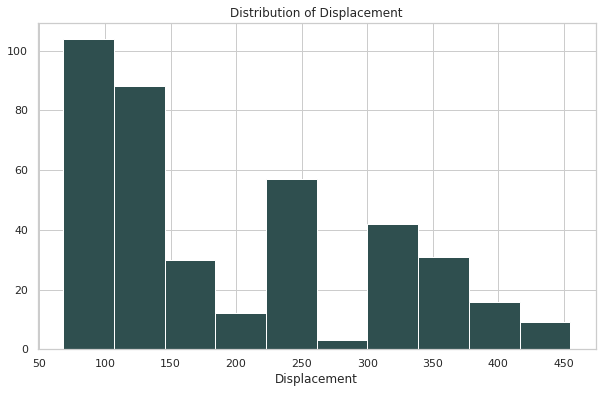

In [24]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(auto.displacement, color="darkslategray")
axes.set_title("Distribution of Displacement")
axes.set_xlabel("Displacement")

plt.show()
plt.close()

A few things jump out. Firstly, We see that there are a lot of records of displacement around 100. Lowest records of displacement are between 250 - 300. There definitely is positive skew here because we see frequent small values followed by rare large values. However, the distribution is not quitely as even as we had expected. 

Further research shows that during the 1970s, due to the oil crises and the gradual tightening of emission-standards, big-block V8s were affected and as a result their use in passenger cars decreased as manufacturers began to phase them out for more efficient designs. Generally speaking, the higher an engine’s displacement the more power it can create, while the lower the displacement the less fuel it can consume. This is mostly likely the reason for the distrubition of our displacement variable.

Reference: https://en.wikipedia.org/wiki/V8_engine

<a id="horsepower"></a>

### Horsepower

*The easiest way for an engine to make more horsepower is to inject more fuel into the cylinder. While this could mean better acceleration or towing capacity, understand that this will negatively affect fuel economy. Vehicles with higher horsepower ratings will generally get worse gas milage. Turbocharging is a clever way to get more power out of a smaller engine while maintaining fuel economy.*

Reference: https://www.yourmechanic.com/article/5-essential-things-to-know-about-horsepower

With this domain knowledge and what we found out about the oil crises in the 1970s, we expect that the data will be positively skewed where we will see frequent lower values followed by rare large values. These lower values will indicate lower horsepower and possibly a more fuel efficient vehicle. We also notice that horsepower is a numerica variable. 

Let's first look at the summary statistics for Horsepower to get a sense for the range actually covered and if there are any anomalies.

In [25]:
auto.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

The minimum horsepower is 46; mean horsepower is 104.469388; median horsepower is 93.50. We can already see that one of our expectation is correct that the data is positively skewed. Furthermore, we notice that the maximum horsepower is 230. Since horsepower is numerical so we can do a histogram.

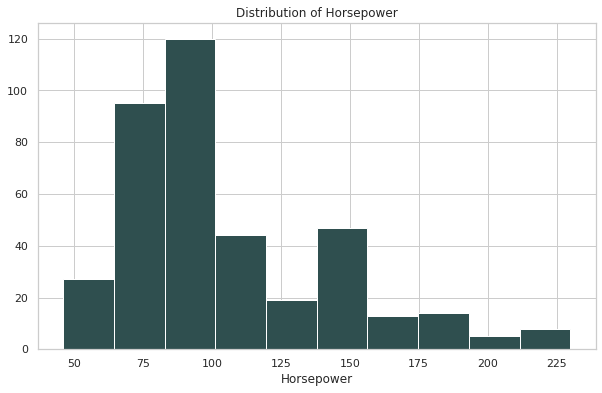

In [26]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(auto.horsepower, color="darkslategray")
axes.set_title("Distribution of Horsepower")
axes.set_xlabel("Horsepower")

plt.show()
plt.close()

Our overall expectation was correct. The data is indeed positively skewed. We notice that there are lot of records of horsepower around 100. We also notice that ~200 horsepower has the lowest number of records. Most common records of horsepower are between 75 - 100.

<a id="weight"></a>


### Weight

Weight is a numerical variable. We expect that cars with lower horsepower, and lower number of cylinders will generally, although not always, weigh less because engine will have less cylinder and therefore will weigh less. We expect to see similar distribution as we saw above for displacement. Since 4 cylinder is the most commonly repeated number of cylinders, we expect to see frequent relatively lower weight vehicles. However, there were some vehicles that had 3 cylinders, so, we expect to see it on the left end as well.

Let's first look at the summary statistics for Weight to get a sense for the range actually covered and if there are any anomalies.

In [27]:
auto.weight.describe()

count     392.000000
mean     2977.584184
std       849.402560
min      1613.000000
25%      2225.250000
50%      2803.500000
75%      3614.750000
max      5140.000000
Name: weight, dtype: float64

Minimum weight is 1613 pounds, and maximum weight is 5140. This is as it should be since it is evident by now that we have some lighter cars for efficiency sake. Mean weight is 2977.584184, and median is 2803.50, again we see positive skew here. Also note that the max vehicle weight is approximately 3 times that of minimum vehicle weight. Weight is numerical so we can do a histogram.

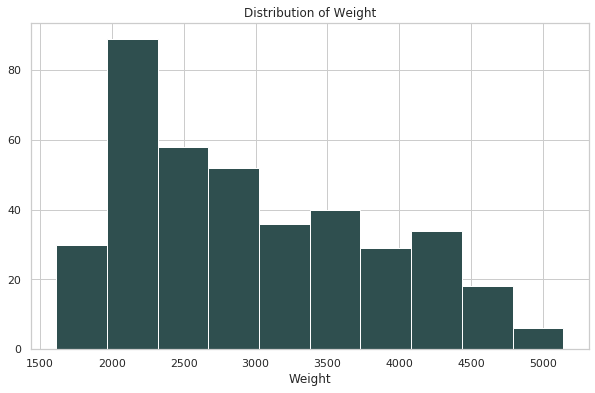

In [28]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(auto.weight, color="darkslategray")
axes.set_title("Distribution of Weight")
axes.set_xlabel("Weight")

plt.show()
plt.close()

This exactly what we were expecting to see. We notice that there are a lot of records of weight around 2000-2500, and there are only few records of weight around 5000 pounds. We also have some "super-light" vehicles as well, as is indicated by low records of vehicle of weight around 1500 - 2000 pounds. Furthermore, research presents the following chart: 

<img src="https://www.epa.gov/sites/production/files/styles/large/public/2020-03/trends2019-highlight4.png">

The chart is provided by the EPA, even though the chart states changes from 1975, the oil crises began in October of 1973, and we notice a significant dip in horsepower, vehicle weight, and increased fuel economy. This matches our expectation too based on the discussion about displacement, horsepower, and now weight. 

Lastly, after the oil shocks of the 1970's, the average weight of American made vehicles had fallen by more than 20 percent, to 3,202 pounds. Furthermore, vehicles made in Japan, and Europe had a mean weight of 3000 pounds. This is also close to our mean weight.

Refence: https://www.supercars.net/blog/cars-by-decade/1970s-cars/

Reference: https://www.epa.gov/automotive-trends/highlights-automotive-trends-report

Reference: https://en.wikipedia.org/wiki/1973_oil_crisis

<a id="acceleration"></a>


### Accerlation

Acceleration is a numeric variable. Natural Resources Canada states that average 0-100 km/h acceleration of cars in 1973 was 19.1 seconds. If we convert this to 0-60 mph, then we get average acceleration of 18.44 seconds. Earlier we had established that we are most likely dealing with 1/4 mile acceleration. We expect to see most cars to have 13 - 18 seconds acceleration.

Let's first look at the summary statistics for Acceleration to get a sense for the range actually covered and if there are any anomalies.

Reference: https://www.nrcan.gc.ca/sites/www.nrcan.gc.ca/files/oee/pdf/transportation/fuel-efficient-technologies/autosmart_factsheet_7_e.pdf

In [29]:
auto.acceleration.describe()

count    392.000000
mean      15.541327
std        2.758864
min        8.000000
25%       13.775000
50%       15.500000
75%       17.025000
max       24.800000
Name: acceleration, dtype: float64

So we notice that minmum acceleration is 8 seconds, we have a fast car, and maximum acceleration is 24.80 seconds, so there is a slow car in the dataset as well. Mean and the median are very close. 15.541327 vs 15.50. The distribution is most likely positively skewed again. We will see frequent lower values followed by some rare larger values.

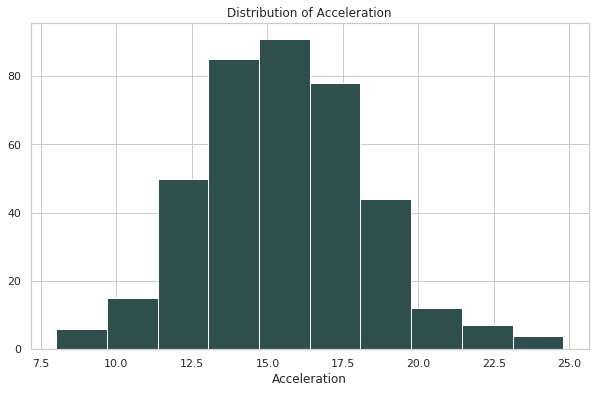

In [30]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(auto.acceleration, color="darkslategray")
axes.set_title("Distribution of Acceleration")
axes.set_xlabel("Acceleration")

plt.show()
plt.close()

We notice that if it were not for the fact that we know mean is greater than the median, and the distribution is positively skewed, we would not be able to tell by looking at the histogram if the distribution is positively skewed. At first glance many may even see normal distribution here. The difference between the mean and the median is only 0.041327 seconds. However, this is what we expected anyway. Most of the records in our dataset have acceleration within 13 - 18 seconds range. We do have some outliers as well. For instance, as we saw in our summary statistics there is a car with 8 seconds acceleration time, and a car with 24.80 seconds acceleration time. 

<a id="origin"></a>

### Origin

Origin is categorical variable. We expect to see three vehicle origin, American, European, and Japanese. Ideally we would expect that no one region will be oversaturated. However, research conducted for variables mentioned above did bring forth the idea that prior, and during the 1970s American vehicles were prominent in the North American market. 

Japanese car makers did not gain significant market share until the late 70s and early 80s. Therefore, realistically speaking, we expect to see American vehicles over-represented followed by Japanese vehicles, and a few European origin vehicles.

**Note**

During the EDA for Cylinder variable we discussed 3 and 5 cylinder vehicles, it is there we learned the origin 1 is US; origin 2 is Europe; and origin 3 is Japan.

Reference: https://www.theglobeandmail.com/globe-drive/adventure/red-line/the-rise-of-japan-how-the-car-industry-was-won/article27100187/

In [31]:
auto.origin.value_counts()

1    245
3     79
2     68
Name: origin, dtype: int64

This is as we had expected. American origin vehicle are over-represented followed by Japanese vehicles, and then some European vehicles. We have a probability of 62.5% that a vehicle is American origin in our dataset; a probability of 20.15% that a vehicle is Japanese; and a probability of 17.34% that a vehicle is European origin.

<a id="carname"></a>


### Car Name

We may have a lot of car names, models, years, and makes. It likely serves as an index value. We expect that there are lot of unique car names here.

In [32]:
auto["car name"].describe()

count           392
unique          289
top       chevrolet
freq             14
Name: car name, dtype: object

So we notice that there are 301 unique cars, and amc matador is the most repeated car in our dataset - it appears 5 times. Research on the car shows that it was relatively popular in the 1970s and in many states it was used as the police car. Not much else can be said about the car name variable. 

Reference: https://en.wikipedia.org/wiki/AMC_Matador#First_generation_(1971%E2%80%931973)

<a id="mpg"></a>


### MPG

MPG is the main variable of interest and represents mpg attained by vehicles in the database. We would expect for there to be a lot of smaller mpgs (reasons provided below) and some excellent mpgs. The data is probably skewed right.  

Based on our analysis above we noticed that the trend was changing in the 70s to more fuel efficient vehciles. However, change is not immediate. People did not simply sell their cars the next day, week, month or year because of the oil crisis. It was a gradual change. Further research on the subject shows the following: 

*In response to the oil price shocks of the early 1970s, Congress passed the nation’s first Corporate Average Fuel Economy (CAFE) standards in 1975. The law called for a doubling of passenger-vehicle efficiency—to 27.5 miles per gallon (mpg)—within 10 years.**

This means that we can expect fuel efficiency of a vehcile from 1970 - 1975 to be approximately 13.75 miles per gallon (assuming that manufacturers preemptively started working towards higher efficiency vehicles, and these vehicles were sold 1975 onwards, with each year leading to higher fuel efficiency in vehicles). Most of the vehicles in our dataset are from origin 1, which America. This means that we can expect many records of vehicles with mpg hovering around 13.75 - 20 mpg, and some cars with greater fuel efficiency.

Reference: https://www.pewtrusts.org/~/media/assets/2011/04/history-of-fuel-economy-clean-energy-factsheet.pdf

We'll start by looking at the summary statistics:

In [33]:
auto.mpg.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

There definitely appears to be some skewness here. The mean is 23.445918 and the median is 22.75. If the mean is greater than the median, the distribution is positively skewed. The 3rd quartile is nearly 3x (2.741 to be precise) the 1st quartile. the minimum is only 9 miles per gallon, while the maximum is 46.60 miles per gallon. 9 miles per gallon is extremely low. Most modern day vehicles perform far better than this. U.S. Department of Energy lists Bugatti Divo as one of the worst mpg cars. It only provides 10 mpg and costs 5,000,000 EUR or $5,937,570.00 USD. Let's plot a histogram of the data.

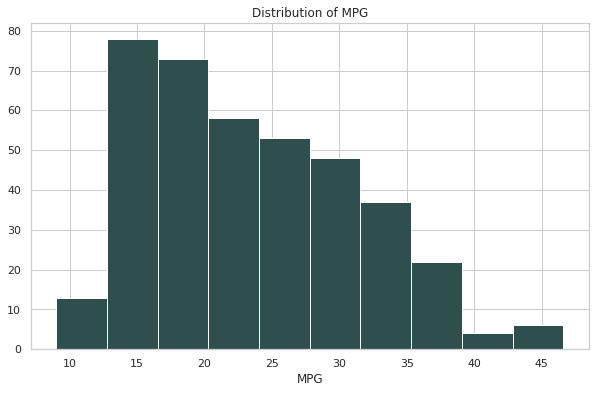

In [34]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(auto.mpg, color="darkslategray")
axes.set_title("Distribution of MPG")
axes.set_xlabel("MPG")

plt.show()
plt.close()

Turns out that our earlier assumption/statement that if the mean is greater than the median, the distribution is positively skewed, holds true here because the distribution appears to be positively skewed. Furthermore, we also notice that vast majority records in our dataset present vehichles with mpg between 15 - 20, with 15 mpg being the most frequent.

Let's see what does Freedman-Diaconis tells us.

In [35]:
def freedman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freedman-Diaconis:  3


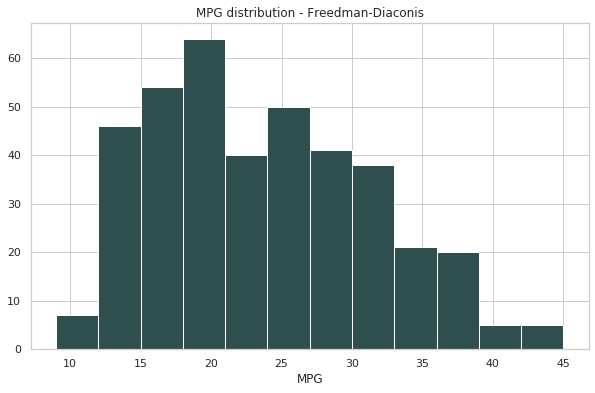

In [36]:
h = freedman_diaconis(auto.mpg)
print("Freedman-Diaconis: ", h)
mn = int(auto.mpg.min())
mx = int(auto.mpg.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(auto.mpg,bins=bins, color="darkslategray")
axes.set_title("MPG distribution - Freedman-Diaconis")
axes.set_xlabel("MPG")

plt.show()
plt.close()

The distribution appears to be positively skewed. There may be a number of factors influencing the distribution. The chief question is, do we have that factor?

[Table of Contents](#toc)

### MPG v. ?

As we have just seen, the mpg data has a positively skewed distribution. In statistics, a positively skewed (or right-skewed) distribution is a type of distribution in which most values are clustered around the left tail of the distribution while the right tail of the distribution is longer. Let us compare mpg to other variables, and see what we can find out about their impact on mpg.

1. [cylinders](#mpgvcylinders)
3. [displacement](#mpgvdisplacement)
4. [horsepower](#mpgvhorsepower)
5. [weight](#mpgvweight)
6. [acceleration](#mpgvacceleration)
7. [origin](#mpgvorigin)
8. [car name](#mpgvcarname)

<a id="mpgvcylinders"></a>

### MPG v. Cylinders

Cyllinders seems like it could be at least one explanatory variable for the mpg. We know from our research above that more cylinders will mean lower mpg. Let's look first at correlation coefficients.

In [37]:
print("r   = ", stats.pearsonr( auto.mpg, auto.cylinders)[0])
print("rho = ", stats.spearmanr( auto.mpg, auto.cylinders)[0])

r   =  -0.7776175081260257
rho =  -0.8231746391245732


Pearson's correlation coefficient, $r$, is ~-0.77 which indicates a strong negative relationship. Spearm's $\rho$ is also interesting at ~-0.823 which might indicates at least a strong monotonic relationship. A negative Spearman correlation coefficient corresponds to a decreasing monotonic trend between X and Y. Since Cylinders is a categorical variable, let's see what information we can obtain by describing by category.

In [38]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [39]:
describe_by_category(auto, "mpg", "cylinders", transpose=True)

cylinders          3           4          5          6           8
count       4.000000  199.000000   3.000000  83.000000  103.000000
mean       20.550000   29.283920  27.366667  19.973494   14.963107
std         2.564501    5.670546   8.228204   3.828809    2.836284
min        18.000000   18.000000  20.300000  15.000000    9.000000
25%        18.750000   25.000000  22.850000  18.000000   13.000000
50%        20.250000   28.400000  25.400000  19.000000   14.000000
75%        22.050000   32.950000  30.900000  21.000000   16.000000
max        23.700000   46.600000  36.400000  38.000000   26.600000


Our previous research and expectation for this comparison was right on the money. We notice here that as the cylinders increase the average mpg drops. We hit peak performance at 4 cylinders - mean of 29.283 mpg. In the plot below we focus our attention to 4, 6, and 8 Cylinders since most of the cars in our dataset follow this convention.

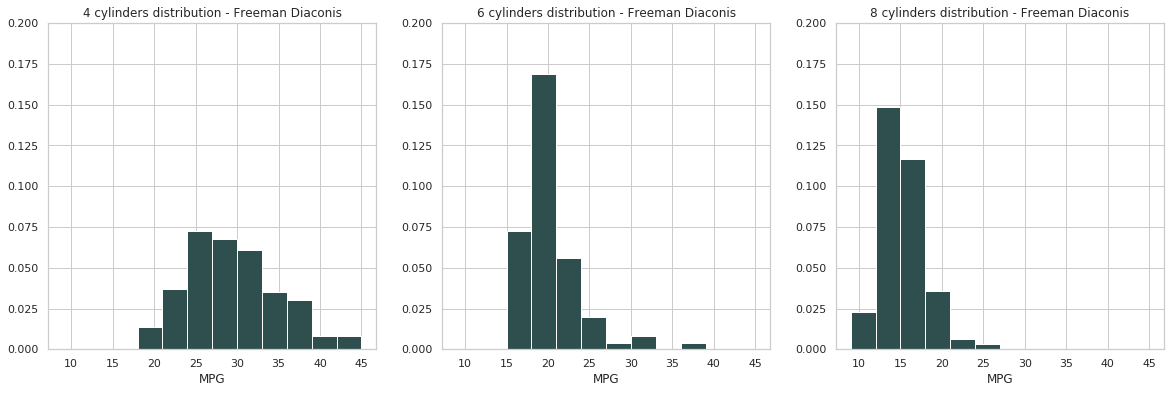

In [40]:
grouped = auto.groupby("cylinders")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 3, 1)
axes.hist(grouped["mpg"].get_group(4),bins=bins,color="darkslategray",density=True)
axes.set_title("4 cylinders distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.20))

axes = figure.add_subplot(1, 3, 2)
axes.hist(grouped["mpg"].get_group(6),bins=bins,color="darkslategray",density=True)
axes.set_title("6 cylinders distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.20))

axes = figure.add_subplot(1, 3, 3)
axes.hist(grouped["mpg"].get_group(8),bins=bins,color="darkslategray",density=True)
axes.set_title("8 cylinders distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.20))

plt.show()
plt.close()

We notice here that we only have few cars with really high mpg - by 1970s standards. Cars with 4 cylinders have more cars with 35+ than 6 cylinders or 8 cylinders vehicles. While cars with 4 cylinders provide a varying degree of fuel efficiency, 6+ cylinders vehciles seem to be saturated around 15 - 20 miles per gallon.

<a id="mpgvdisplacement"></a>

### MPG v. Displacement

Displacement seems like it could be at least one explanatory variable. More displacement in a vehcile would mean that it performs poorly when it comes to fuel efficiency. Engine displacement is a determining factor in the horsepower and torque that an engine produces, as well as how much fuel that engine consumes. Let's look first at correlation coefficients.

Reference: https://www.yourmechanic.com/article/what-is-engine-displacement

In [41]:
print("r   = ", stats.pearsonr( auto.mpg, auto.displacement)[0])
print("rho = ", stats.spearmanr( auto.mpg, auto.displacement)[0])

r   =  -0.8051269467104586
rho =  -0.8552335882841172


Pearson's correlation coefficient, $r$, is ~-0.80 which indicates a strong negative relationship. Spearm's $\rho$ is also interesting at ~-0.85 which might indicates at least a strong monotonic relationship. Furthermore, we have stronger relationship than with Cylinders. Let's plot the data:

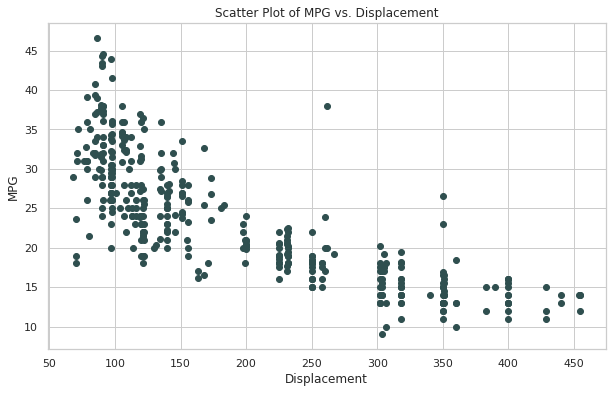

In [42]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( auto.displacement, auto.mpg, marker="o", color="darkslategray")

axes.set_ylabel("MPG")
axes.set_xlabel("Displacement")
axes.set_title("Scatter Plot of MPG vs. Displacement")

plt.show()
plt.close()

As expected we see a monotonically decreasing relationship. We notice that there are some outliers as well. For instance there are vehicles that have high displacement, and high MPG. Let's take a look at these vehicles to satisfy our curiousity about the outliers.

In [43]:
auto.loc[(auto["mpg"] > 22) & (auto["displacement"] > 250)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
298,23.0,8,350.0,125.0,3900.0,17.4,79,1,cadillac eldorado
300,23.9,8,260.0,90.0,3420.0,22.2,79,1,oldsmobile cutlass salon brougham
364,26.6,8,350.0,105.0,3725.0,19.0,81,1,oldsmobile cutlass ls
387,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel)


So we notice that these vehicles serve as outliers. All of the outliers have origin 1, 3 of them are 8 cylinder vehicles, and 1 is 6 cylinder. These vehicles were manufacturered between 79-82. There are 3 oldsmobile on the list as outliers. However, overall there is a trend that as the displacement increases the MPG goes down.

<a id="mpgvhorsepower"></a>

### MPG v. Horsepower

Horsepower seems like it could be at least one explanatory variable. More horsepower in a vehcile would mean that it performs poorly when it comes to fuel efficiency. The easiest way for an engine to make more horsepower is to inject more fuel into the cylinder. While this could mean better acceleration or towing capacity, understand that this will negatively affect fuel economy. Vehicles with higher horsepower ratings will generally get worse gas milage. Turbocharging is a clever way to get more power out of a smaller engine while maintaining fuel economy. Let's look first at correlation coefficients.

Reference: https://www.yourmechanic.com/article/5-essential-things-to-know-about-horsepower

In [44]:
print("r   = ", stats.pearsonr( auto.mpg, auto.horsepower)[0])
print("rho = ", stats.spearmanr( auto.mpg, auto.horsepower)[0])

r   =  -0.7784267838977775
rho =  -0.8536164024453882


Pearson's correlation coefficient, $r$, is ~-0.77 which indicates a strong negative relationship. Spearmans's 𝜌 is also interesting at ~-0.85 which might indicate that at least a strong monotonic relationship. Let's plot the data:

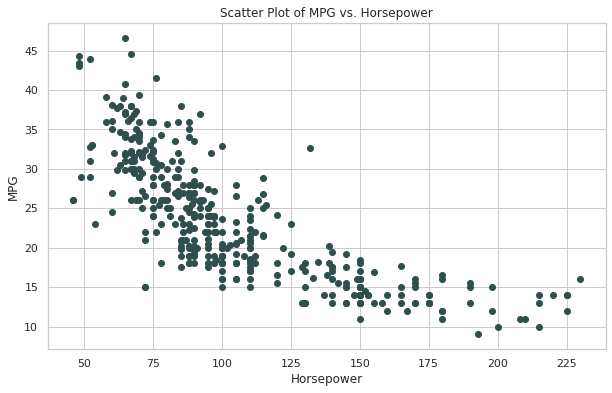

In [45]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( auto.horsepower, auto.mpg, marker="o", color="darkslategray")

axes.set_ylabel("MPG")
axes.set_xlabel("Horsepower")
axes.set_title("Scatter Plot of MPG vs. Horsepower")

plt.show()
plt.close()

We notice that the relationship is monotonically decreasing as expected. We are also able to satisfy our expectation that lesser horsepower generally mean better fuel efficiency and higher mpg. Furthermore, we notice that the mpg is sort of clustered. For instance, if we look at vehicles with horse power between 75 - 100, they all seem to be clustered in 15 - 35 mpg range approximately. There are some outliers as well. There is a car in our dataset that has 125+ horsepower and provides roughly 32-33 mpg. We can find out which car is able to provide this level of performance.

In [46]:
auto.loc[(auto["mpg"] > 30) & (auto["horsepower"] > 125)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
333,32.7,6,168.0,132.0,2910.0,11.4,80,3,datsun 280-zx


So 1980 Datsun 280-zx had 6 cylinders, and provided 32.7 mpg, this is definitely our outlier in this category. Continuing with our analysis; also, not all vehicles with lower horsepower provide highest efficiency, there is a vehicle with ~75 horsepower but only provides 15 mpg. We can find out which car is this. 

In [47]:
auto.loc[(auto["mpg"] == 15) & (auto["horsepower"] < 75)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
154,15.0,6,250.0,72.0,3432.0,21.0,75,1,mercury monarch
155,15.0,6,250.0,72.0,3158.0,19.5,75,1,ford maverick


We notice that both vehicles have 6 cylinders, made in the same year, same displacement, same horsepower, and same origin.

Point here is that there are definitely outliers, some cars that perform better than expected, and some worse than expected. However, overall trend says that with increasing horsepower, we see decreasing fuel efficiency. 

Lastly, if we look very carefully at the graph, we will notice that between 100 - 125 horsepower we see mpgs stacked. Could this be because of competition between manufacturers offering horsepower between 100-125 mg leading to varying degree of mpgs in this class of vehicle? 

Let see what more information we can obtain by flipping the chart, although our expectation is that it will not add much extra to our analysis, it is still worth looking at.

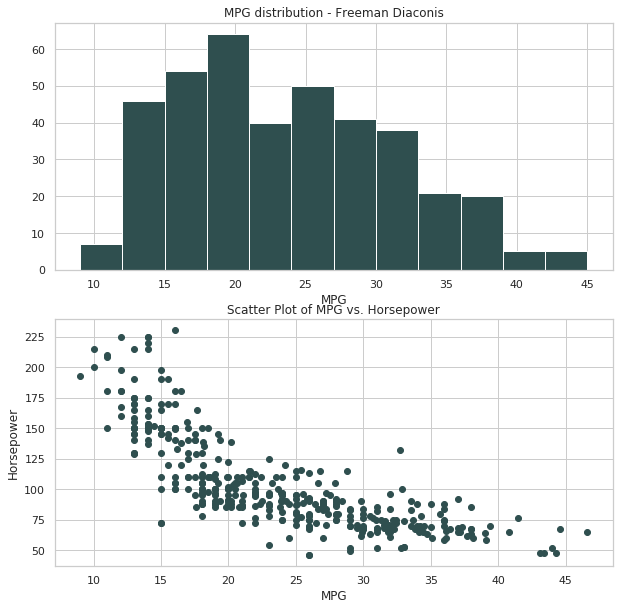

In [48]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(2, 1, 1)
axes.hist(auto.mpg,bins=bins,color="darkslategray")
axes.set_title("MPG distribution - Freeman Diaconis")
axes.set_xlabel("MPG")

axes = figure.add_subplot(2, 1, 2)
axes.scatter( auto.mpg, auto.horsepower, marker="o", color="darkslategray")

axes.set_ylabel("Horsepower")
axes.set_xlabel("MPG")
axes.set_title("Scatter Plot of MPG vs. Horsepower")

plt.show()
plt.close()

The bottom chart simply treats MPG as the x-axis. We notice here the same trend as we saw above - monotinically decreasing. We also see the same outliers as well. Furthermore, we see that most of the cars that provide mpg $\geq$ 20, have less than or equal to 125 horsepower. 

<a id="mpgvweight"></a>

### MPG v. Weight

There could be some negative correlation between weight and MPG, and we may again see monotonically decreasing relationship. The reason for this expectation is that as the car gets heavier, we need more displacement, which requires more horsepower, and as we saw above, horsepower is negatively correlated. Let's look first at correlation coefficients.

In [49]:
print("r   = ", stats.pearsonr( auto.mpg, auto.weight)[0])
print("rho = ", stats.spearmanr( auto.mpg, auto.weight)[0])

r   =  -0.8322442148315757
rho =  -0.8755851198739869


Pearson's correlation coefficient, 𝑟, is ~-0.83 which indicates a stronger negative relationship. Spearmans's 𝜌 is also interesting at ~-0.87 which indicates a strong monotonic relationship. Furthermore, this is the strongest relationship yet. Let's plot the data:

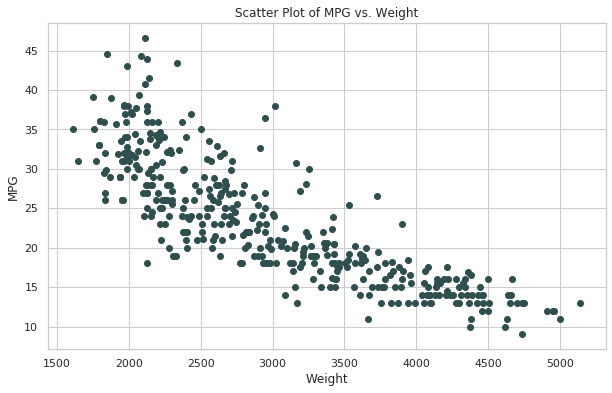

In [50]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( auto.weight, auto.mpg, marker="o", color="darkslategray")

axes.set_ylabel("MPG")
axes.set_xlabel("Weight")
axes.set_title("Scatter Plot of MPG vs. Weight")

plt.show()
plt.close()

There are some outliers but that is to be expected since we have encountered these in previous comparisons. Specifically we notice that some heavier vehicles are able to provide a relatively higher MPG. Engineering feat? Let's take a look at these cars.  

In [51]:
auto.loc[(auto["weight"] > 2800) & (auto["mpg"] > 27)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
299,27.2,4,141.0,71.0,3190.0,24.8,79,2,peugeot 504
327,36.4,5,121.0,67.0,2950.0,19.9,80,2,audi 5000s (diesel)
328,30.0,4,146.0,67.0,3250.0,21.8,80,2,mercedes-benz 240d
333,32.7,6,168.0,132.0,2910.0,11.4,80,3,datsun 280-zx
359,28.1,4,141.0,80.0,3230.0,20.4,81,2,peugeot 505s turbo diesel
360,30.7,6,145.0,76.0,3160.0,19.6,81,2,volvo diesel
387,38.0,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel)


So these vehicles are outliers. We notice that vast majority of heavier vehicles are not origin 1 vehicles. As a matter of factor there is only 1 origin 1 vehicle amongst our outliers. We also see datsun 280-zx again. Datsun was an outlier when it comes to horsepower, and again when it comes to weight. In general this car is heavier, has more horsepower, and weight, has 6 cylinders, and still performs equally as well as 4 cylinders cars. Lastly, we notice that Oldsmobile Cutlass Ciera (diesel) has the highest mpg of all the cars listed, and it too has 6 cylinders. 

<a id="mpgvacceleration"></a>

### MPG v. Acceleration

Per our research could be some correlation between acceleration and MPG. According to the EPA report, Quantitative Effects of Acceleration Rate on Fuel Consumption, published in 1980: 

*One factor which has a significant effect on vehicle fuel consumption is the rate at which the vehicle is accelerated. Quantitative and qualitative studies have shown that more rapid and/or more frequent accelerations result in increased fuel consumption.*

Reference: https://nepis.epa.gov/Exe/ZyNET.exe/9100WZVZ.txt?ZyActionD=ZyDocument&Client=EPA&Index=1976%20Thru%201980&Docs=&Query=&Time=&EndTime=&SearchMethod=1&TocRestrict=n&Toc=&TocEntry=&QField=&QFieldYear=&QFieldMonth=&QFieldDay=&UseQField=&IntQFieldOp=0&ExtQFieldOp=0&XmlQuery=&File=D%3A%5CZYFILES%5CINDEX%20DATA%5C76THRU80%5CTXT%5C00000019%5C9100WZVZ.txt&User=ANONYMOUS&Password=anonymous&SortMethod=h%7C-&MaximumDocuments=1&FuzzyDegree=0&ImageQuality=r75g8/r75g8/x150y150g16/i425&Display=hpfr&DefSeekPage=x&SearchBack=ZyActionL&Back=ZyActionS&BackDesc=Results%20page&MaximumPages=1&ZyEntry=2

However, our previous research did not mention anything concrete about acceleration and its impact on mpg. At this point in time we can expect that there might be positive correlation. Furthermore, this is during the era when manufacturers had started to carefully look at the mpg, and one way to increase mpg is to increase acceleration time. Report from MIT states that acceleration can be traded off against other vehicle attributes, including fuel economy. All else being equal, larger improvements in acceleration performance over time mean smaller improvements in fuel economy, leading to higher energy consumption.

Reference: http://web.mit.edu/sloan-auto-lab/research/beforeh2/files/MacKenzie%20&%20Heywood%20-%20TRB%20-%2012-1475.pdf

Essentially as if decrease acceleration time, mpg also goes down. So we expect some positive correlation. Let's look first at correlation coefficients.

In [52]:
print("r   = ", stats.pearsonr( auto.mpg, auto.weight)[0])
print("rho = ", stats.spearmanr( auto.mpg, auto.acceleration)[0])

r   =  -0.8322442148315757
rho =  0.44153885845636487


Pearson's correlation coefficient, 𝑟, is ~0.42 which indicates a weak postive relationship. Spearmans's 𝜌 is also interesting at ~0.44 which indicates a weak monotonic relationship. Lastly, our expectation was correct since we see a positive relationship here. Also, this is the weakest relationship observed thus far. Let's plot the data:

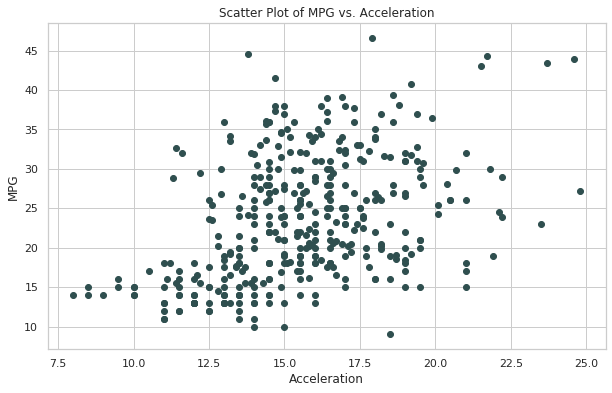

In [53]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( auto.acceleration, auto.mpg, marker="o", color="darkslategray")

axes.set_ylabel("MPG")
axes.set_xlabel("Acceleration")
axes.set_title("Scatter Plot of MPG vs. Acceleration")

plt.show()
plt.close()

Here we notice that the data points are quite scattered with some presence of outliers. Overall trend is that as we increase acceleration time, MPG also increases but as we saw above the correlation is quite weak, and we cannot properly witness a monotonically increasing relationship either. Most of the data we have is clustered between 12.5 to 20 seconds acceleration time with varying degree of MPG between 10-40 MPG. 

<a id="mpgvmodelyear"></a>

### MPG v. Model Year

Model year may show negative correlation. Based on our research above, we expect that older models will have poor mpg as compared to the new models, especially those prior to 1975 (congress passed a legislation requiring for improvement in mpg around this time). Since model year is a categorical variable, let see what we get by describing by category. 

In [54]:
describe_by_category(auto, "mpg", "model year", transpose=False)

            count       mean       std   min     25%    50%     75%   max
model year                                                               
70           29.0  17.689655  5.339231   9.0  14.000  16.00  22.000  27.0
71           27.0  21.111111  6.675635  12.0  15.000  19.00  27.000  35.0
72           28.0  18.714286  5.435529  11.0  13.750  18.50  23.000  28.0
73           40.0  17.100000  4.700245  11.0  13.000  16.00  20.000  29.0
74           26.0  22.769231  6.537937  13.0  16.000  24.50  27.500  32.0
75           30.0  20.266667  4.940566  13.0  16.000  19.50  23.000  33.0
76           34.0  21.573529  5.889297  13.0  16.750  21.00  26.375  33.0
77           28.0  23.375000  6.675862  15.0  17.375  21.75  30.000  36.0
78           36.0  24.061111  6.898044  16.2  19.350  20.70  28.000  43.1
79           29.0  25.093103  6.794217  15.5  19.200  23.90  31.800  37.3
80           27.0  33.803704  6.885854  19.1  29.800  32.70  37.650  46.6
81           28.0  30.185714  5.635319

In order to further our analysis we need to find out the average before 75 and after 75. First we look at after 75.

In [55]:
auto[auto["model year"] >= 75].describe()["mpg"]

count    242.000000
mean      26.065289
std        7.653304
min       13.000000
25%       19.400000
50%       25.500000
75%       32.000000
max       46.600000
Name: mpg, dtype: float64

Here we notice that the average mpg after 75 (inclusive) was 26.065 with a median of 25.50. Furthermore, we also get a maximum mpg of 46.60 during this time period as well. 

In [56]:
auto[auto["model year"] < 75].describe()["mpg"]

count    150.000000
mean      19.220000
std        5.999855
min        9.000000
25%       14.000000
50%       18.000000
75%       24.000000
max       35.000000
Name: mpg, dtype: float64

Here we notice that mpg prior to 75 (exclusive) was 19.22 with a median of 18. Furthermore, we also get a maximum mpg of 35 during this time period. So we can expect to see some positive correlation here. Let's look at the correlation coefficients.

In [57]:
print("r   = ", stats.pearsonr( auto.mpg, auto["model year"])[0])
print("rho = ", stats.spearmanr( auto.mpg, auto["model year"])[0])

r   =  0.5805409660907846
rho =  0.5748408744472727


Pearson's correlation coefficient, 𝑟, is ~0.58 which indicates a relatively strong postive relationship. Spearmans's 𝜌 is also interesting at ~0.57 which indicates a relatively strong monotonic relationship. Lastly, our expectation was correct since we see a positive relationship here. Also, this relationship is better than acceleration but not on par with previously observed relationships. Below we plot the data but we are only interested in prior to 75 and after 75 since it is quite evident by now that this was the turning point. Let's plot the data:

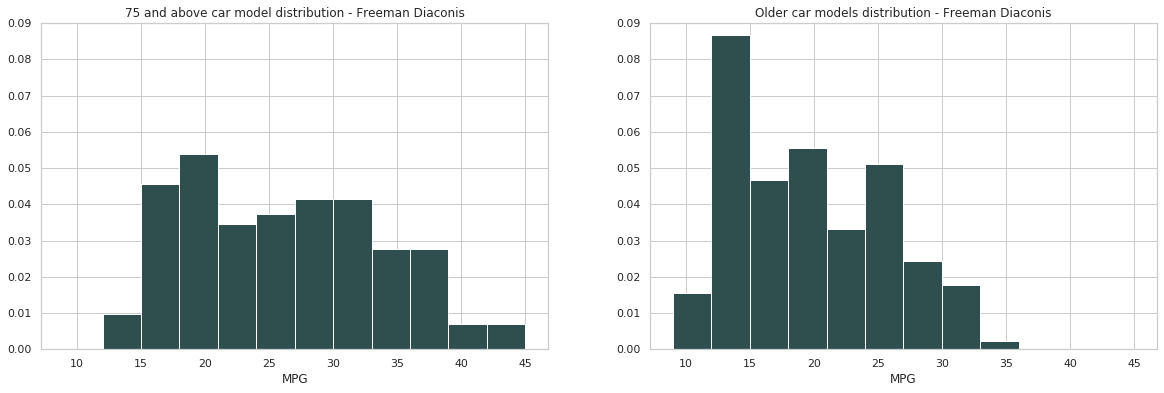

In [58]:
auto_copy = auto.copy()

auto_copy.loc[df['model year'] >= 75, 'model_year'] = 1 
auto_copy.loc[df['model year'] < 75, 'model_year'] = 0

grouped = auto_copy.groupby("model_year")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["mpg"].get_group(1),bins=bins,color="darkslategray",density=True)
axes.set_title("75 and above car model distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.09))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["mpg"].get_group(0),bins=bins,color="darkslategray",density=True)
axes.set_title("Older car models distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.09))

del auto_copy

plt.show()
plt.close()

Car models produced 75 and after have a varying degree of fuel efficiency, whereas this does not seem to be the case with older models, this is evident by the density of the graphs. Density of 20 MPG appears to be on par in both graphs. We see a sharp decline in below 15 MPG after 75, and a more uniform-like distribution to other varieties of MPGs as well. 

<a id="mpgvorigin"></a>

### MPG v. Origin

Origin will be an interesting variable. We expect that vehicles made in origin 1 will have lower mpg, and if this were not the case there would not be a need to lower the speed limits on highway to 55mph and to pass a legistlation requiring better fuel economy. It was around this time Japanese vehicles started to shine because they had better fuel economy. Therefore we expect that origin 3 cars most likely have the highest fuel economy. Since origin is a categorical variable, let see what we get by describing by category. 

In [59]:
describe_by_category(auto, "mpg", "origin", transpose=True)

origin           1          2          3
count   245.000000  68.000000  79.000000
mean     20.033469  27.602941  30.450633
std       6.440384   6.580182   6.090048
min       9.000000  16.200000  18.000000
25%      15.000000  23.750000  25.700000
50%      18.500000  26.000000  31.600000
75%      24.000000  30.125000  34.050000
max      39.000000  44.300000  46.600000


This is very conclusive. We see here that on average origin 1 vehicles have the lowest mpg, and origin 3 vehicles have the highest. Origin 2 vehicles are closer to origin 3 in their mpg. While maximum mpg obtained by origin 1 vehicle is 39, origin 3 vehicle obtains 46.60 mpg, and origin 2 vehicle obtains 44.30. For all 3 origins we notice median less than the mean implying right skew. Based on this information we can also state that it is likely origin has positive correlation with mpg. Let's find out. 

In [60]:
print("r   = ", stats.pearsonr( auto.mpg, auto.origin)[0])
print("rho = ", stats.spearmanr( auto.mpg, auto.origin)[0])

r   =  0.5652087567164604
rho =  0.5804824209039191


Pearson's correlation coefficient, 𝑟, is ~0.56 which indicates a relatively strong postive relationship. Spearmans's 𝜌 is also interesting at ~0.58 which indicates a relatively strong monotonic relationship. Lastly, our expectation was correct since we see a positive relationship here. Also, this relationship is not entirely better than model year. For instance, when we looked at mpg v. model year we had 𝑟 = ~0.58, and 𝜌 = ~0.57. Correlation was better for model year, than origin, and rho is better for origin for origin than it was for model year - but only slightly and it is quite competitive. Let's plot the data:

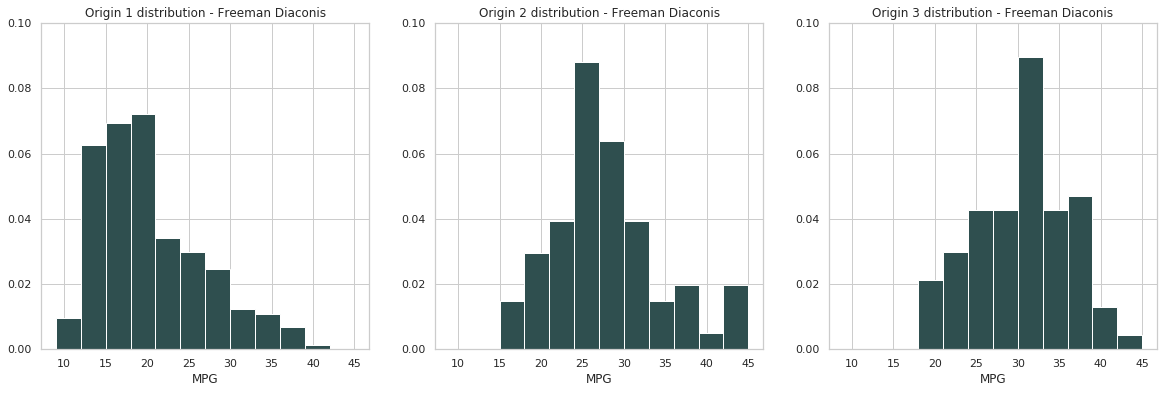

In [61]:
grouped = auto.groupby("origin")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 3, 1)
axes.hist(grouped["mpg"].get_group(1),bins=bins,color="darkslategray",density=True)
axes.set_title("Origin 1 distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.1))

axes = figure.add_subplot(1, 3, 2)
axes.hist(grouped["mpg"].get_group(2),bins=bins,color="darkslategray",density=True)
axes.set_title("Origin 2 distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.1))

axes = figure.add_subplot(1, 3, 3)
axes.hist(grouped["mpg"].get_group(3),bins=bins,color="darkslategray",density=True)
axes.set_title("Origin 3 distribution - Freeman Diaconis")
axes.set_xlabel("MPG")
axes.set_ylim((0,0.1))

plt.show()
plt.close()

Freedman-Diaconis lets us automatically generate a "number of buckets", by working out how big each bucket should be. We notice here that while the density of 10 - 20 mpg cars is highest for origin 1, whereas origin 3's is clearly between 30 - 35 mpg, and origin 2's is 25 - 30. Also, it appears that there is greater density of 45 mpg in origin 2 than origin 1 and 3 combined. 

<a id="mpgvcarname"></a>

### MPG v. Car Name

We do not expect this variable to be of any concequence. A car's name simply does not determine the mpg it will provide. If this were the case most if not all manufacturers will choose the names that optimize the fuel economy. Perhaps if we create a new column 'manufacturer', and then do a plot maybe we will see some sort of a relationship? Even then, we already know that if car is manufactured in origin 1, it will have lower mpg than compared to the cars made in origin 2, and 3. Let's check it out anyway.

In [62]:
auto_copy = auto.copy()
auto_copy["manufacturer"] = ""

gm = ["chevrolet", "pontiac", "buick", "oldsmobile", "cadillac", "opel"]
ford = ["mercury", "capri"]
chrysler = ["plymouth", "fiat"]
vm = ["audi"]
mercedes = ["mercedes-benz"]


for index, row in auto_copy.iterrows():
    car_name = row["car name"]
    manufacturer = car_name.split()[0]
    if manufacturer in gm:
        manufacturer = "gm"
    elif manufacturer in ford:
        manufacturer = "ford"
    elif manufacturer in chrysler:
        manufacturer = "chrysler"
    elif manufacturer in mercedes:
        manufacturer = "mercedes"
    auto_copy.loc[index, "manufacturer"] = manufacturer

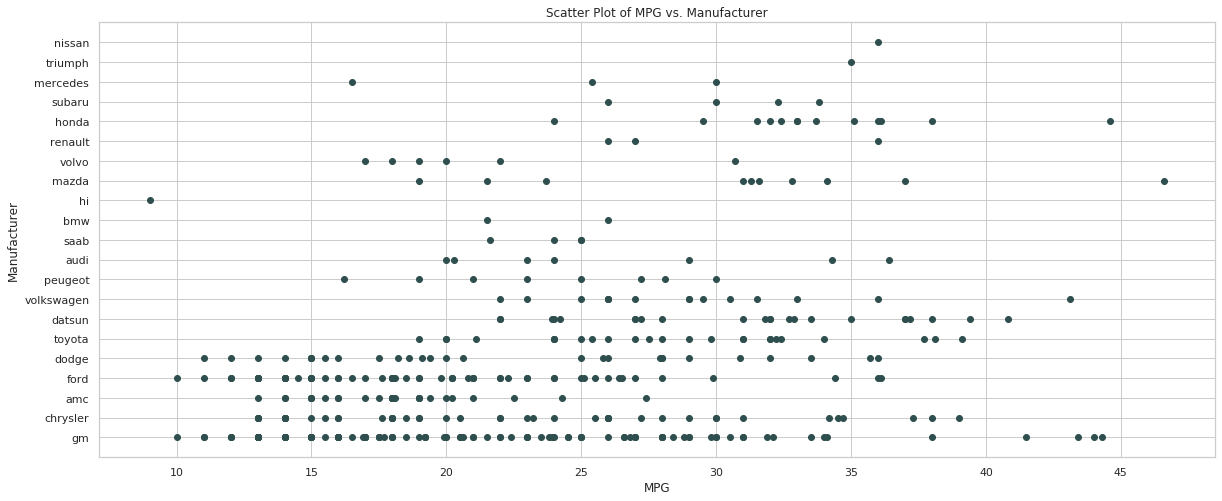

In [63]:
figure = plt.figure(figsize=(20, 8))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(auto_copy.mpg, auto_copy.manufacturer, marker="o", color="darkslategray")

axes.set_ylabel("Manufacturer")
axes.set_xlabel("MPG")
axes.set_title("Scatter Plot of MPG vs. Manufacturer")

plt.show()
plt.close()

We see a wide range of cars, and mpgs. We notice that GM produces a wide variety of cars that attain all kinds of fuel economy. GM's lowest performing car attains 10mpg and their highest is somewhere close to 44mpg. We notice a few outliers as well. Lowest mpg is attained by a car called hi, and the highest mpg is attained by mazda. 

There are not as many Mercedes as one might have expected. We only notice 3 data points of mercedes on this scatter plot. This could be due to the fact that vast majority of our data is saturated with origin 1 manufacturers. Lastly, we notice that vast majority of origin 1 manufacturers are clustered closer to the lower end of the mpg. 

[Table of Contents](#toc)

<a id="buildthemodel"></a>

## 1.3 - Build the model

1. [Final Model](#finalmodel)
2. [Model Evaluation](#modelevaluation)

Above we conducted ETL, and EDA of the data provided. Now we build the model. However, before we do that let's once again take a look at some key information. It is also convenient to have it placed here instead of going back-and-forth. 

In [64]:
auto["year"] = auto["model year"]
auto = auto.drop(columns="model year")
auto.reset_index(drop=True, inplace=True)

In [65]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,origin,car name,year
0,18.0,8,307.0,130.0,3504.0,12.0,1,chevrolet chevelle malibu,70
1,15.0,8,350.0,165.0,3693.0,11.5,1,buick skylark 320,70
2,18.0,8,318.0,150.0,3436.0,11.0,1,plymouth satellite,70
3,16.0,8,304.0,150.0,3433.0,12.0,1,amc rebel sst,70
4,17.0,8,302.0,140.0,3449.0,10.5,1,ford torino,70


In [66]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   origin        392 non-null    int64  
 7   car name      392 non-null    object 
 8   year          392 non-null    int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 27.7+ KB


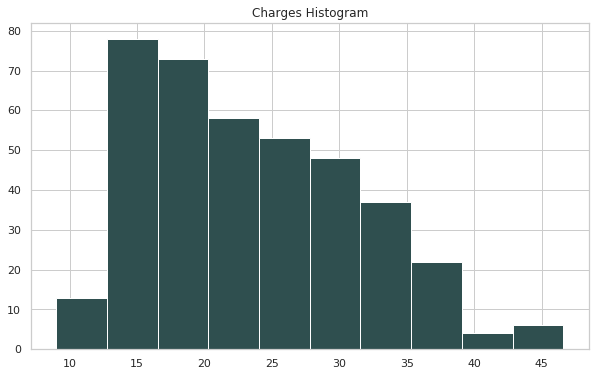

In [67]:
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1,1,1)
axes.hist(auto.mpg, color="darkslategray")
axes.set_title("Charges Histogram")
plt.show()
plt.close()    

Recall that in our EDA that MPG is positively skewed. Let's review some of what we covered in our pairwise EDA with target variable, MPG.

* cylinders - definitely has a negative impact on mpg. We saw that higher number of cylinders led to a lower overall mpg. 
* displacement - higher displacement means we have more cylinders, and more cylinders mean lower mpg - therefore displacement has a negative impact on mpg. 
* horsepower - as with displacement, higher horsepower led to a lower mpg.
* weight - heavier cars require more power to move them, therefore we generally need more cylinders, displacement, and horsepower to move them, which leads lower mpg.
* acceleration - weak positive correlation with mpg, below 50%. 
* model year - categorical variable, semi-strong positive relationship with mpg.
* origin - categorical variable, semi-strong positive relationship with mpg.
* car name - of no consequence. 

Even though we have summarized all the variables we need not concern ourselves with every single one of them because of minimal impact on mpg. 

Furthermore, since are using a linear model, it is also important to look at the correlation coefficients between each variable and the target, and each other. Let's get the dummy variables

In [68]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [69]:
correlations(auto, "mpg", ["cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin"])

,feature,r,rho
0,cylinders,-0.777618,-0.823175
1,displacement,-0.805127,-0.855234
2,horsepower,-0.778427,-0.853616
3,weight,-0.832244,-0.875585
4,acceleration,0.423329,0.441539
5,year,0.580541,0.574841
6,origin,0.565209,0.580482


This is exactly what we have expected to see. Let's go over this information to summarize: 

1. **cylinders** - as we saw in the EDA, there is negative relationship, and Spearman's suggests that the relationship is monotonically decreasing.

2. **displacement** - as we saw in the EDA, there is negative relationship, and Spearman's suggests that the relationship is monotonically decreasing. However, displacement has more of an impact than cylinders, if we can say that. 

3. **horsepower** - as we saw in the EDA, there is negative relationship, and Spearman's suggests that the relationship is monotonically decreasing.

4. **weight** - as we saw in the EDA, there is negative relationship, and Spearman's suggests that the relationship is monotonically decreasing.

5. **acceleration** - as we saw in the EDA, there is a weak positive relationship, and Spearman's suggests that the relationship is monotonically increasing - but when we plot it this is quite faint.

6. **model year** - as we saw in the EDA, there is positive relationship, and Spearman's suggests that the relationship is monotonically increasing. However, when we looked at the graph above, it was only faintly indicative of this fact. The relationship is mostly borderline. 

7. **origin** - as we saw in the EDA, there is psoitive relationship, and Spearman's suggests that the relationship is monotonically increasing. Again, for this feature too the graph only indicated faint monotonically increasing relationship.

Before estimating any linear models, let's look at the Null model (the mean):


In [70]:
auto.mpg.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

We covered this in our EDA, but we reiterate it here. The lowest mpg is 9 and the highest is 46.60 and the mean is 23.445918 with a standard deviation of 7.805007. We can treat std as the $\sigma$ of our Null model. 

We can now try to build a model based on what we know so far.

In [71]:
model1 = "mpg ~ cylinders + displacement + horsepower + weight + acceleration +  year + origin"
result1 = models.bootstrap_linear_regression(model1, data=auto)
models.describe_bootstrap_lr(result1)

$R^2$ is 82% which is really good. This means that the model explains 82% of the variation in mpg. The error has been cut in half compared to the Null model to 3.33. We noticed earlier that MPG distribution appears to be positively skewed or right skewed. Let's take a look at the coefficients:

**intercept** is not of great interest, but it is worth noting here - it does not make much sense for the features to equal to 0 for our vehicle.

**cylinders** is -0.49 we can say that it has mixed support in the data.

**displacement** is 0.02 and has mixed support in the data - this was not entirely expected.

**horsepower** is -0.02 and we can say that it has mixed support in the data.

**weight** is -0.01 and again we can say that it has strong support in the data - as was expected.

**acceleration** 0.08, and it has mixed support in the data - was not expected to be positive.

**year** is 0.75 and is relatively strongly supported by the data.

**origin** 1.43, and is likely to be strongly supported by the data.

From the first model we learn the following:

1. We may have to remove displacement, and acceleration because results were not expected and not meaningful. Therefore, it might be worth considering excluding it from the model.
2. MPG is not positively skewed so we may be required to transform.

Lastly, note that $R^2$ is a non-decreasing monotonic function of the number of variable. Therefore, we check adjusted $R^2$.

In [72]:
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

In [73]:
adjusted_r_squared(result1)

0.8172720625761635

In general our $R^2$ of 82% without any changes is really good. Our adjusted $R^2$ is not much different. As a matter of fact, it can be rounded to 82%. Furthermore, we noticed that the standard deviation of 3.33 is not too large either; our model halves it compared to our Null model.

Continuing with our earlier thought process, let us see how the model is impacted if we remove displacement as one of our variables.

In [74]:
model2 = "mpg ~ cylinders + horsepower + weight + year + origin"
result2 = models.bootstrap_linear_regression(model2, data=auto)
models.describe_bootstrap_lr(result2)

We notice here that even after removing displacement, and acceleration from our model, our $R^2$ is still at 82%. Furthermore, $\sigma$ is a bit higher here 3.35 vs 3.33 but not by much. Let's see what adjusted $R^2$ has to show us.

In [75]:
adjusted_r_squared(result2)

0.8147641121792681

In [76]:
print("Model1: {0}".format(models.adjusted_r_squared(result1)))
print("Model2: {0}".format(models.adjusted_r_squared(result2)))

Model1: 0.8172720625761635
Model2: 0.8147641121792681


Not a lot of difference here. We may be okay leaving acceleration, and displacement out of our model. 

Let's take a look at the residuals:

In [77]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(30,10))

    variables = variables

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(auto[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="darkslategray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

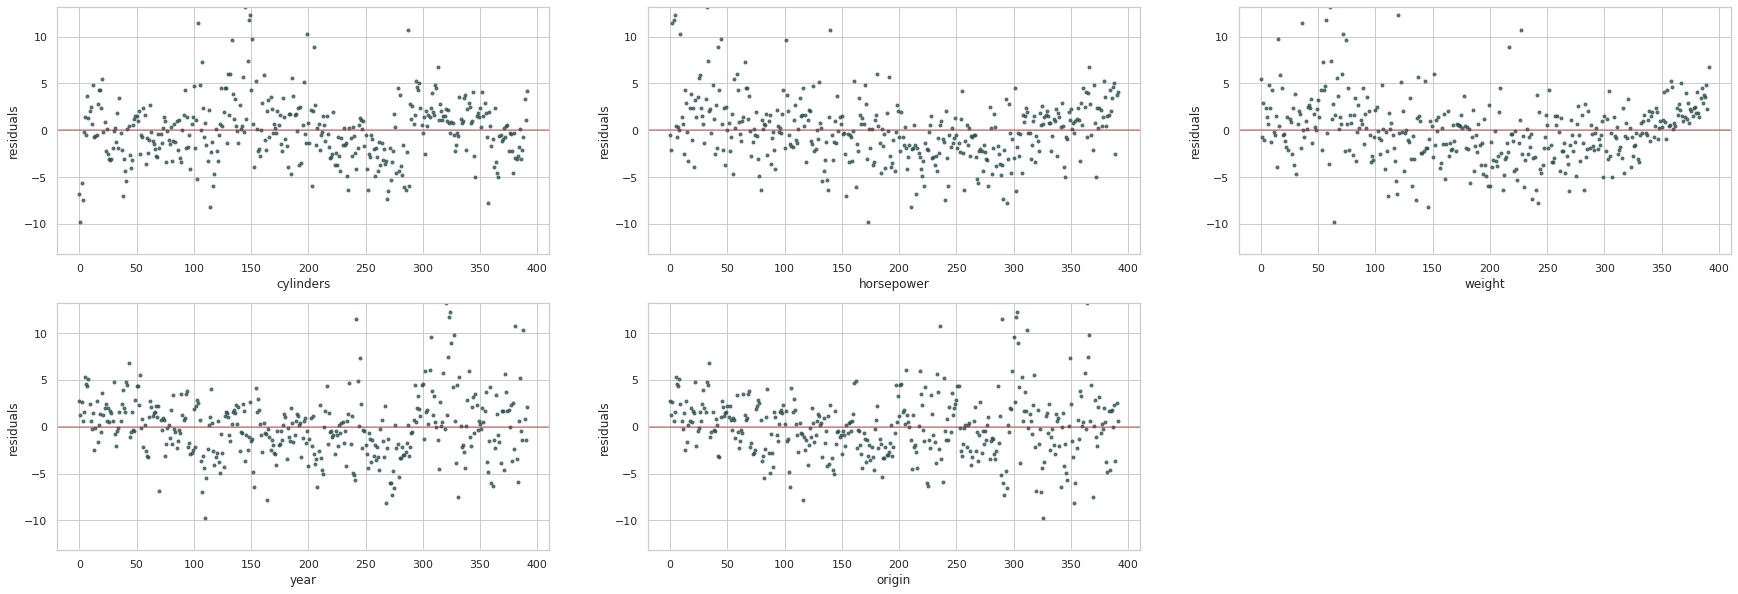

In [78]:
residuals2 = plot_residuals(result2, ['cylinders', 'horsepower','weight', 'year', 'origin'])

We don't get a very linear relationship here. Furthermore, we notice that there weight variable takes sort of a parabola like shape, and same thing with the horsepower variable. We may need to transform these later. 

We can begin by transforming mpg variable through log (mentioned earlier that it is not normally distributed and is skewed), which we do as follow:

In [79]:
auto["log_mpg"] = auto["mpg"].apply(np.log)

Let's see a histogram:

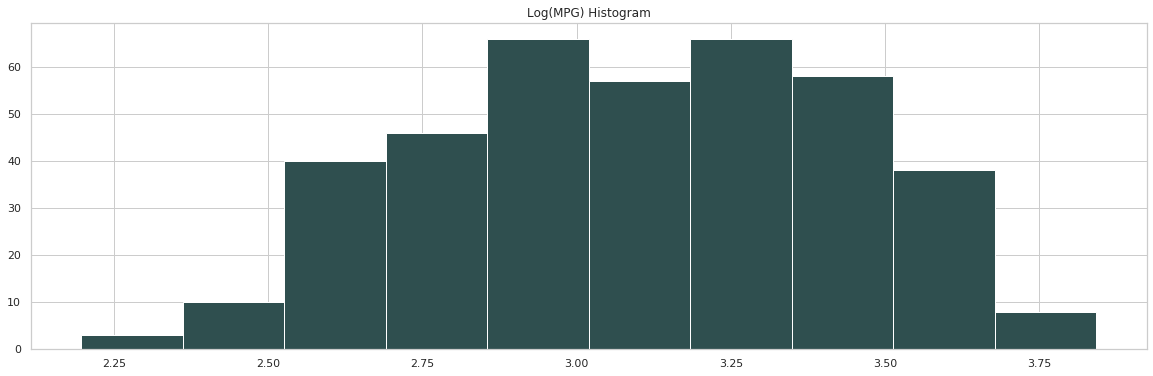

In [80]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(auto.log_mpg, color="darkslategray")
axes.set_title("Log(MPG) Histogram")
plt.show()
plt.close()

This looks better than before. It's not exactly normally distributed but is very close and is fairly symmetric. We can try to use this as our response variable:

In [81]:
model3 = "log_mpg ~ cylinders + horsepower + weight + year + origin"
result3 = models.bootstrap_linear_regression(model3, data=auto)
models.describe_bootstrap_lr(result3)

Great! So we notice here that $R^2$ is much better and $\sigma$ is 0.12, which is even better! However, there is a slight problem here. Applying log function to mpg has caused other variables to become minuscule. Let's apply log to these other variables as well. 


In [82]:
auto["log_cylinders"] = auto["cylinders"].apply(np.log)
auto["log_horsepower"] = auto["horsepower"].apply(np.log)
auto["log_weight"] = auto["weight"].apply(np.log)

In [83]:
model4 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + year + origin"
result4 = models.bootstrap_linear_regression(model4, data=auto)
models.describe_bootstrap_lr(result4)

Better than what it was but we do not see a lot of increase in $R^2$. Model 3 gave us $R^2 = 0.88$ and right now we have $R^2= 0.89$. It is still better. And our $\sigma$ is also lower at 0.11 vs 0.12.

Let's take a look at the residuals:

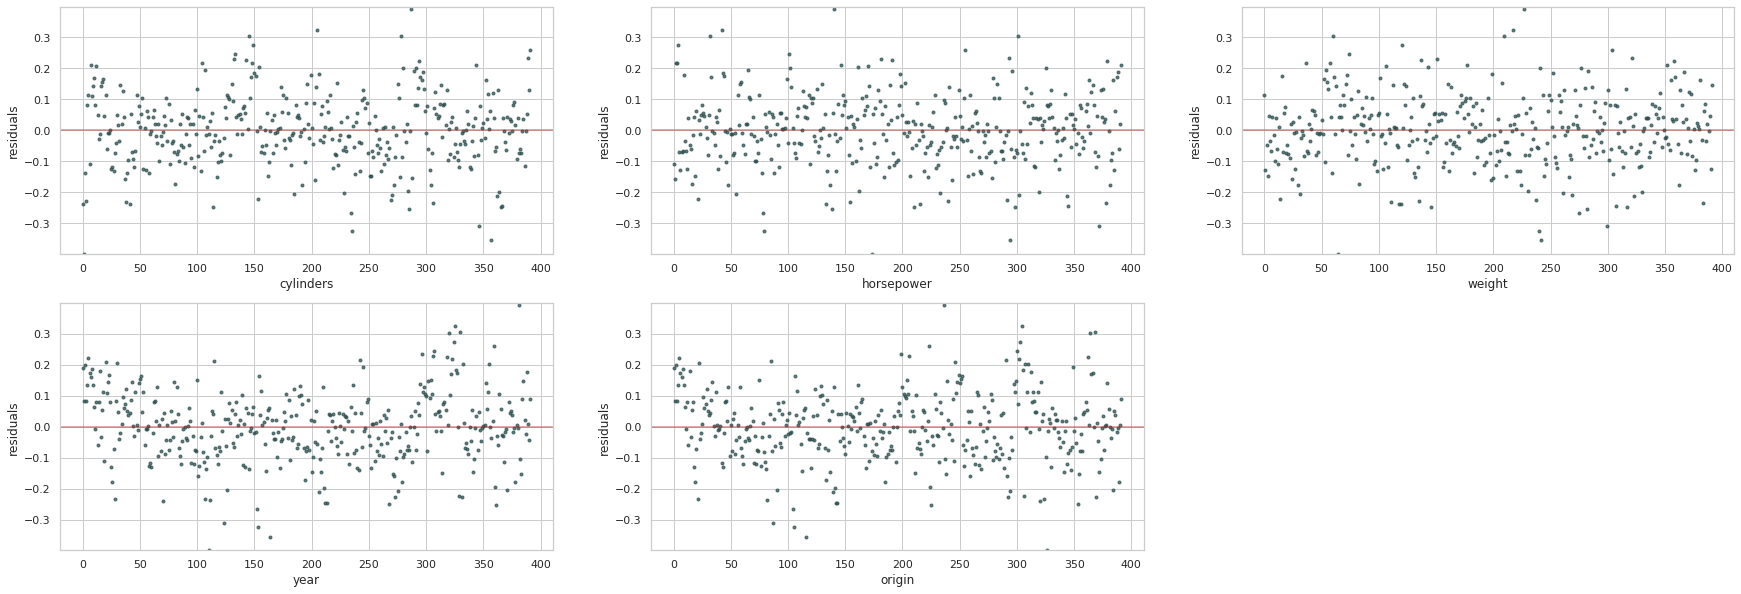

In [84]:
residuals4 = plot_residuals(result4, ['cylinders', 'horsepower','weight','year', 'origin'])

There appears to be some symmetry in our errors. We can see if our model can be improved by applying interaction terms. Our EDA provided us some valuable insights and we will rely on those here. We know based on our EDA that year and origin have a huge role to play for reasons previously discussed. Let's see how these come into play in our model.

In [85]:
model6 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + year + origin + year:origin"
result6 = models.bootstrap_linear_regression(model6, data=auto)
models.describe_bootstrap_lr(result6)

Not much improvement here. We are still seeing old values of $R^2$ and $\sigma$. Let's try something else.

In [86]:
model7 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + year + origin + log_horsepower:log_weight"
result7 = models.bootstrap_linear_regression(model7, data=auto)
models.describe_bootstrap_lr(result7)

Again, not much improvement here. We are still seeing old values of $R^2$ and $\sigma$.

In [87]:
model8 = "log_mpg ~ log_cylinders + log_horsepower + log_weight + year + origin + log_cylinders:log_horsepower + log_horsepower:log_weight"
result8 = models.bootstrap_linear_regression(model7, data=auto)
models.describe_bootstrap_lr(result8)

We are not improving or at least not by much. It is highly likely that this could be our final model. Note that even interaction terms did not do much for us. Before finalizing we will take a look at adjusted $R^2$ to make sure we are covering our ground here, and not missing something that we should have been paying attention to all along.

In [88]:
print("Model4: {0}".format(models.adjusted_r_squared(result4)))
print("Model8: {0}".format(models.adjusted_r_squared(result4)))

Model4: 0.8864213724822729
Model8: 0.8864213724822729


Model4 does not have any interaction terms. Model8 is with interaction terms and even adjusted $R^2$'s are equal. At this point we can finalize model 4 since interaction terms did not add anything extra. 

<a id="finalmodel"></a>

### Final Model

In [89]:
model = "log_mpg ~ log_cylinders + log_horsepower + log_weight + year + origin"
result = models.bootstrap_linear_regression(model, data=auto)
models.describe_bootstrap_lr(result)

And the residuals of this model are (we discussed these earlier):

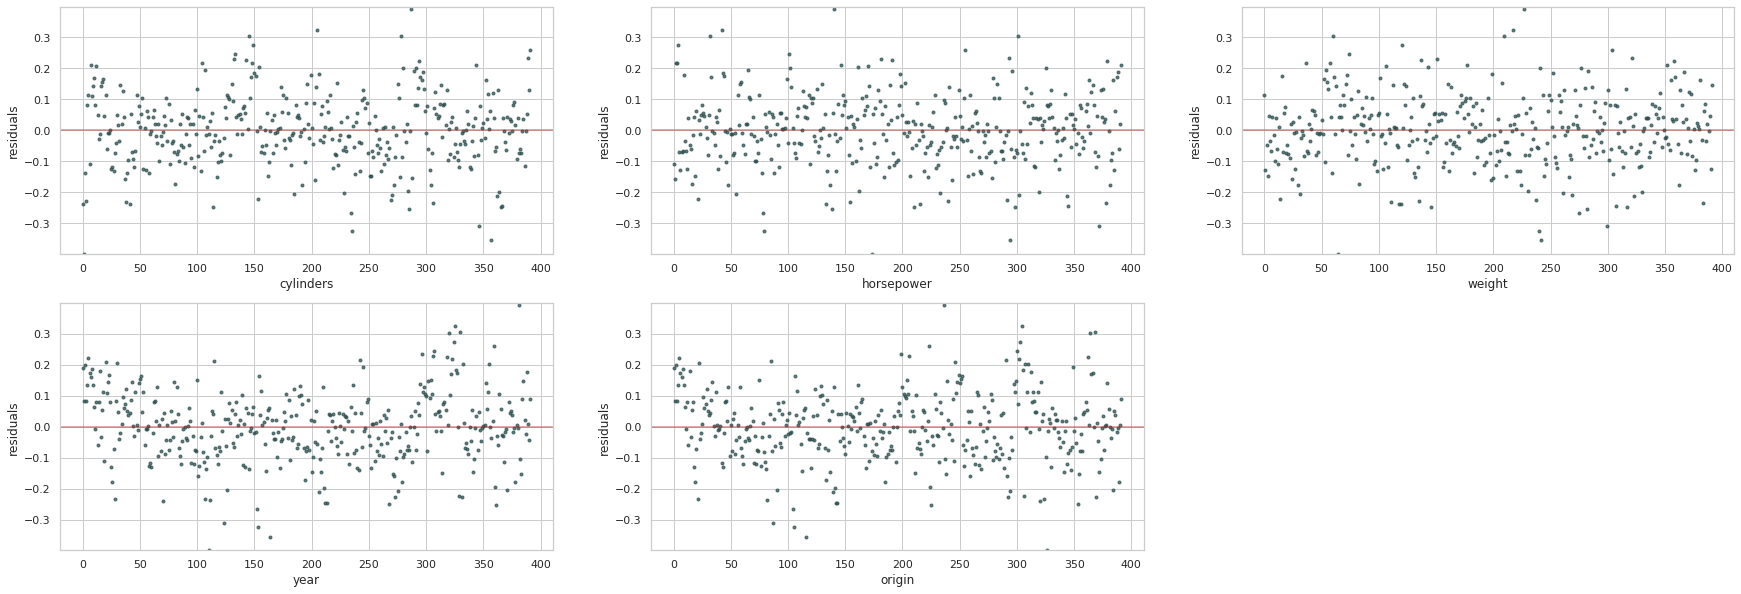

In [90]:
residuals = plot_residuals(result, ["cylinders", "horsepower", "weight", "year", "origin"])

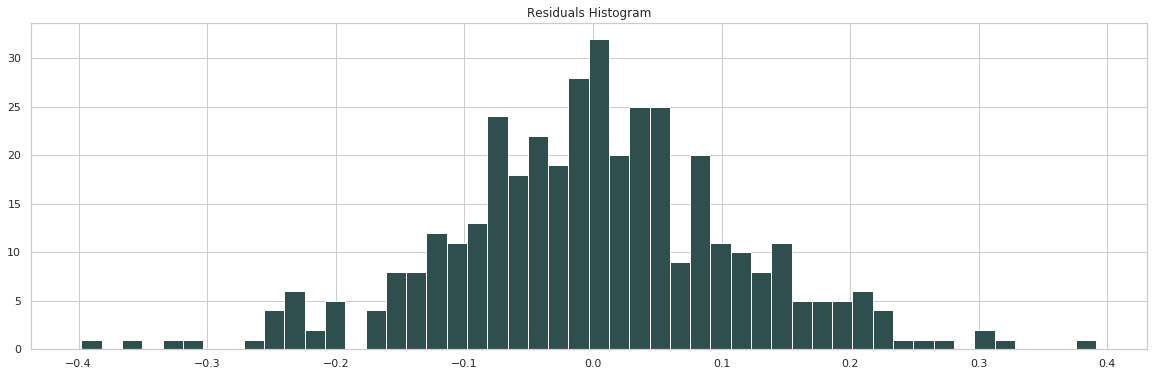

In [91]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(residuals, bins=50, color="darkslategray")
axes.set_title("Residuals Histogram")
plt.show()
plt.close()  

There might be some other analysis we can do but this appears to be the bulk of it for our final model. The $R^2$ is really good at 0.89, and $\sigma$ at 0.11. All the variables in the model make sense. Lastly, our residuals appear to be very closely normally distributed. We can say that this is our model.

<a id="modelevaluation"></a>

### Model Evaluation

Now that we have our final model, we must evaluate it. For this we rely on the code from Lab 11. This code has been reproduced below for convenience.

In [92]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

We need to perform 10 fold cross validation on our data, for this 2-3 iterations are fine. We also need to calculate 95% Bootstrap estimates of the CI for both $R^2$ and the $\sigma$. Let's run `cross_validation` on our model and data:

In [93]:
formula = model
result = cross_validation(models.linear_regression, formula, auto, lambda r: (r["sigma"], r["r_squared"]))

In our analysis and results above, we have $\sigma$ and $R^2$ and the 95% credible intervals for our metric. We have 30 estimates of each metric. This should be sufficient for us to estimate the credible bounds. We can simply obtain the quantiles because as mentioned in Lab 11, 3 rounds of 10 fold cross validation is already a kind of Bootstrap estimate of the metric:

In [94]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result], [0.025, 0.975]))

95% CI for sigma: [0.10338053 0.14308853]


In [95]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result], [0.025, 0.975]))

95% CI for R^2: [0.81024799 0.91509911]


We can state that there is 95% probability that $R^2$ falls between 0.82 to 0.95; 95% that $\sigma$ falls between 0.08 to 0.15, approximately. Let's take a look at the mean values:

In [96]:
sigmas = [r[0] for r in result]
r_squareds = [r[1] for r in result]

In [97]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  0.12259347512274348
mean R^2:  0.8835974611942026


These values are very close to our original model. Our model provides us $\sigma = 0.11$ and $R^2 = 0.89$, and here we notice mean $\sigma = 0.12316729487333446$ and mean $R^2 = 0.883135988414368$.

In [98]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [99]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [100]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [0.11883853 0.12650529]


In [101]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.87286938 0.89229169]


We have obtained fairly tight bounds here on what we think the average $\sigma$ and $R^2$ are for our model. There is 95% probability for $\sigma$ to be between 0.11 to 0.12 and $R^2$ to be between 0.875 to 0.897, approximately. This is much tighter than what we had obtained earlier.

Now we want to plot ever increasing chunks of the test data to simulate getting more data. This could potentially us find out if we are in a high bias or high variance situation.

In [102]:
result = learning_curves(models.linear_regression, formula, auto, lambda r: r["sigma"])

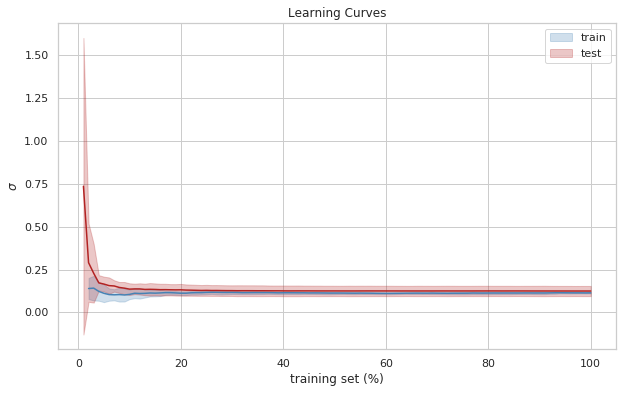

In [103]:
plot_learning_curves(result, r"$\sigma$")

The graph above tells us that our model is fairly good. We are in low bias low variance state. Therefore, getting and adding more data is not going to improve our model. One last thing we should probably do is check the mean squared error of our model. 

In [104]:
def mse(residuals):
    errors = residuals
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return ((1.0/n)*squared_error)

In [105]:
mse(residuals)

0.012864684770056893

When dealing with linear regression, one of our goals or rather aim is to minimize the mean squared error, and here we notice that the chosen model really minimizes this. Our MSE is ~0.012.

Overall we can say that we have a good model. To recap, we noticed the following: 

1. There is 95% probability for $\sigma$ to be between 0.11 to 0.12 and $R^2$ to be between 0.869 to 0.894, approximately.
2. we are in low bias low variance state. 
3. And, our final model is:

In [106]:
model = "log_mpg ~ log_cylinders + log_horsepower + log_weight + year + origin"
result = models.bootstrap_linear_regression(model, data=auto)
models.describe_bootstrap_lr(result)

[Table of Contents](#toc)

<a id="describethemodel"></a>

## 1.4 - Describe the model

Now we describe our model. Note that in our final model we only have the following variables:

1. log_mpg 
2. log_cylinders
3. log_horsepower
4. log_weight
5. year
6. origin

It is worth mentioning again that MPG is our target variable.

1. **log_mpg**: In log_mpg we have the log of mpg feature values. What this means for us is that, given the values and inputs we will get a log value of the mpg. Since we are using natural log of values, we will need to use exponent function to get the actual mpg value from this.


2. **log_cylinders**: This is our second variable. The coefficient for log_cylinders is -0.06. This means that for every increase in 1 log of cylinders, we are looking at a decrease of about 0.06 in log of mpg. To recap what we learned in our EDA: Pearson's correlation coefficient, is ~-0.77 which indicates a strong negative relationship. Spearman's is also interesting at ~-0.823. These variables indicate negative relationship, which is exactly what we see here. The 95% bounds here are -0.15 to 0.02. This means that there is 95% probability that our coefficient is between -0.15 and 0.02. 


3. **log_horsepower**: This is our third variable. The coefficient for log_horsepower is -0.16. This means that for every increase in 1 log of horsepower, we are looking at a decrease of about 0.16 in log of mpg. To recap what we learned in our EDA: Pearson's correlation coefficient, is ~-0.77 which indicates a strong negative relationship. Spearmans's is also interesting at ~-0.85 which might indicate that at least a strong monotonic relationship. We see a negative relationship here as well. This is as we should have expected anyway. The 95% bounds here are -0.25 to -0.06. This means that there is 95% probability that our coefficient is between -0.25 and -0.06.


4. **log_weight**: This is our fourth variable. The coefficient for log_weight is -0.66. This means that for every increase in 1 log of weight, we are looking at a decrease of about 0.66 in log of mpg. We noticed this in our EDA too, note that when a car is heavier it required more cylinders, more displacement to move it. Therefore, as the weight increased the fuel efficiency went down. Thus far it is one of the strongest relationship witnessed. To recap: Pearson's correlation coefficient, is ~-0.83 which indicates a stronger negative relationship. Spearmans's is also interesting at ~-0.87 which indicates a strong monotonic relationship (decreasing). The 95% bounds here are -0.80 to -0.58. This means that there is 95% probability that our coefficient is between -0.80 and -0.58.


5. **year**: The model year has a coefficient of 0.03, so for every year later the car was made the log of mpg will increase by 0.03. Note that in our EDA we found out that time went on MPG got better because of the legislation and basically need of the hour situation due to the oil crises. The 95% bounds here are 0.03 to 0.03. This means that there is 95% probability that our coefficient is 0.03.


6. **origin**: We noted that most of the cars were from origin 1. Note that origin is categorical data. We have three possible values for origin. We can say here as the origin changes we see an increase of 0.02 in log of mpg. The 95% bounds here are 0.01 to 0.03. This means that there is 95% probability that our coefficient is between 0.01 to 0.03.

At this point it is also worth mentioning that $\beta_0$ is 7.06. This means that all else equal to 0, we have mpg of 7.06. How can this be possible? A car without any cylinders, displacement, horsepower, acceleration, and weight still provides mpg? This is not possible. However, it is worth noting it here anyway.

[Table of Contents](#toc)

<a id="usethemodel"></a>

## 1.5 - Use the model

We can now start using the model. 

**Plan** 

There are few things that we can do, and there is some curiosity that we can satisfy. For instance, we should always attempt to make a prediction on data that our model has not seen before, but we check to see how the predictions look to satisfy curiosity. Then 

In [107]:
prediction_data = auto.copy()
prediction_data = prediction_data.drop(columns=["log_mpg", "log_cylinders", "log_horsepower", "log_weight"])

In [108]:
def predict(df):
    beta_0 = result['coefficients'][0]
    beta_1 = result['coefficients'][1]
    beta_2 = result['coefficients'][2]
    beta_3 = result['coefficients'][3]
    beta_4 = result['coefficients'][4]
    beta_5 = result['coefficients'][5]
    
    df["predictions"] = np.NAN
    
    for index, row in df.iterrows():
        prediction = beta_0 + beta_1 * np.log(float(row["cylinders"])) + beta_2 * np.log(float(row["horsepower"])) + beta_3 * np.log(float(row["weight"])) + beta_4 * row["year"] + beta_5 * row["origin"]
        df.at[index, "predictions"] = np.exp(prediction)
    return df

Now that we have our function to make some predictions, let's predict using our model. Our aim should always be to predict using a data that our model has not seen before, but out of curiosity let's see anyway. This is the reason why the above function was created.

In [109]:
predicted = predict(prediction_data)

Let's get some information from our predicted model to see how we did.

In [110]:
predicted["predictions"].describe()

count    392.000000
mean      23.284734
std        7.151575
min       11.246622
25%       17.483568
50%       23.176798
75%       28.852601
max       40.967209
Name: predictions, dtype: float64

In [111]:
predicted["mpg"].describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

We notice here that the mean of our prediction is 23.28, and the mean of actual is 23.45 we managed to get really close! Also note that the standard deviation is of actual is 7.80, and our prediction says 7.15, also very close. Actual maximum value is 46.60, and we predicted that it should be 40.96, close but there is still a meaningful difference here. Lastly, we predicted a higher minimum value than actual minimum, 11.24 vs 9.00. This satisfies our curiosity about making prediction on the data that has already been seen by our model, lets actually make a prediction.

**Note**: I tried using the predicted function on page 51 of fundamentals_module11.pdf but could not get the appropriate or meaningful results. Could possibly be my approach. Therefore, I created the function below.

In [112]:
def prediction(cylinders, horsepower, weight, year, origin):
    beta_0 = result['coefficients'][0]
    beta_1 = result['coefficients'][1]
    beta_2 = result['coefficients'][2]
    beta_3 = result['coefficients'][3]
    beta_4 = result['coefficients'][4]
    beta_5 = result['coefficients'][5]
    return np.exp(beta_0 + beta_1 * np.log(float(cylinders)) + beta_2 * np.log(float(horsepower)) + beta_3 * np.log(float(weight)) + beta_4 * year + beta_5 * origin)

Now we have our prediction function let's see what prediction we can make from it. We make two types of predictions, one based on mean values, and the other based on domain knowledge that we collected on cars that are not in the dataset. 

We will use 4 cylinders. Cylinders is categorical variable and averaging it does not make sense, and most of the cars in our dataset have 4 cylinders. 

In [113]:
prediction_data.horsepower.mean()

104.46938775510205

Our car will have 104 horsepower

In [114]:
prediction_data.weight.mean()

2977.5841836734694

Our car weighs 2977.584 pounds. We treated year of the car as a categorical variable. Also, note that cars before 75 were poor performers (see EDA), and cars after 75 were performing much better. Cars made in origin 3 performed better than all others. Let say that our car model year is 73 (see EDA - most of the cars in our dataset are from 73).

In [115]:
predicted = prediction(4, 104, 2977.584, 73, 1)
predicted

19.598660259290327

So, according to our prediction if a car was manufactured in origin 1 in 73, and has 4 cylinders with 104 horsepower, and weighs approximately 2977.584 pounds, its mpg should be 19.59. Let's check the 95% bounds of our estimate.

In [116]:
print("({0:.2f},{1:.2f})".format(predicted - 2*result["sigma"], predicted + 2*result["sigma"]))

(19.37,19.83)


There is 95% probability that our mpg is between 19.37 - 19.83. This is a tight bound. However, is this better than null model? The mean standard deviation of mpg's are:

In [117]:
mean_mpg = prediction_data.mpg.mean()
std_mpg = prediction_data.mpg.std()
print("mpg = {0:.2f}({1:.2f})".format(mean_mpg, std_mpg))

mpg = 23.45(7.81)


So far any car regardless of the characteristics, we would predict an mpg of 23.45 and the 95% bounds would be:

In [118]:
print("({0:.2f},{1:.2f})".format(mean_mpg - 2*std_mpg, mean_mpg + 2*std_mpg))

(7.84,39.06)


Our model, and the predictions provided by it are somewhat on par, we are able to make a prediction with great precision. Also note that while there 95% probability that mean_mpg is within 7.84 to 39.06 bound, we have a 95% probability that our predicted mpg is between 21.22 to 21.67 so the bounds are definitely a lot tighter here.

Now let's make a prediction based on a car that is not in our dataset. 

* Car name: Subaru 1400 (also called Subaru Leone)
* Cylinders: 4-cylinder
* Weight: 1706 pounds
* Horsepower: 67
* Year: 1976
* Origin: 3
* mpg: 33/39 (city/hwy)

**Reference**

https://en.wikipedia.org/wiki/Subaru_Leone

https://blog.consumerguide.com/5-most-fuel-efficient-cars-of-1976/

But before we actually test on this car, let's make sure 100% that this car is not in our dataset.

In [119]:
prediction_data[prediction_data["car name"].str.contains("subaru")]

,mpg,cylinders,displacement,horsepower,weight,acceleration,origin,car name,year,predictions
148,26.0,4,108.0,93.0,2391.0,15.5,3,subaru,74,24.923326
237,30.0,4,97.0,67.0,1985.0,16.4,3,subaru dl,77,32.638386
328,33.8,4,97.0,67.0,2145.0,18.0,3,subaru dl,80,33.866746
342,32.3,4,97.0,67.0,2065.0,17.8,3,subaru,81,35.817500


As we can see we do not have Subaru 1400 or Subaru Leone in our dataset. Note that Subaru made quite a few cars around that time that had 67 horsepower and all around the same mpg. We are expecting that our prediction will be around the 30-40 mpg mark. Let's see if we can actually make a meaningful prediction.

In [120]:
predicted = prediction(4, 67, 1706, 76, 3)
predicted

35.13272167744777

So, according to our prediction the car provides 35.13 miles per gallon. This is very close to the actual. Let's check the 95% bounds of our estimate.

In [121]:
print("({0:.2f},{1:.2f})".format(predicted - 2*result["sigma"], predicted + 2*result["sigma"]))

(34.90,35.36)


There is 95% probability that our mpg is between 34.90 - 35.36. This is a tight bound. And, we know that sometimes we do not get the advertised mpg, so perhaps we would get somewhere between 34.90 to 35.60 mpg in real life scenario. Regardless, there is 95% probability that our mpg is between 34.90 - 35.36, and this bodes well our model when compared to actual advertised mpg.

[Table of Contents](#toc)



---

**CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.



*   Have you completed every section and answered every question asked?
*   For every question, have you described your approach and explained your results?
*   Have you checked for spelling and grammar errors?
*   Are your code blocks free of any errors?
*   Have you *SAVED* your notebook?

